Data Poisoning Attack on Normal MNIST Dataset:

In [ ]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

In [ ]:
# Load the MNIST dataset
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)


/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [ ]:
# Split the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Attacker injects poisoned samples
poisoned_indices = [0, 1, 2, 3]  # Example: Assume the first 4 samples are poisoned
poisoned_labels = ['7', '9', '2', '1']


In [ ]:
# Modify the labels of the poisoned samples
y_train[poisoned_indices] = poisoned_labels


In [ ]:
# Train a random forest classifier on the poisoned dataset
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [ ]:
# Evaluate accuracy on the clean test data
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy on clean data:", accuracy)

Accuracy on clean data: 0.9672142857142857


Data Poisoning Attack on Federated MNIST Dataset:

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms

In [ ]:
# Define a simple federated learning setup
class LocalModel(nn.Module):
    def __init__(self):
        super(LocalModel, self).__init__()
        self.fc = nn.Linear(784, 10)

    def forward(self, x):
        return self.fc(x)

In [ ]:
# Load the MNIST dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])


In [ ]:
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)


100%|██████████| 9912422/9912422 [00:00<00:00, 436288866.50it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 42623396.84it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 128725224.22it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 5239419.35it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [ ]:
# Split the dataset into clients
num_clients = 2
data_per_client = len(train_dataset) // num_clients
data_indices = list(range(len(train_dataset)))

np.random.seed(42)
np.random.shuffle(data_indices)

clients_data = []
for i in range(num_clients):
    client_indices = data_indices[i * data_per_client : (i+1) * data_per_client]
    clients_data.append(torch.utils.data.Subset(train_dataset, client_indices))


In [ ]:
# Attacker poisons one client's data
poisoned_client_index = 0
poisoned_indices = [0, 1, 2, 3]  # Example: Assume the first 4 samples in the first client's data are poisoned
poisoned_labels = [7, 9, 2, 1]

poisoned_client_data = clients_data[poisoned_client_index].dataset
for idx, label in zip(poisoned_indices, poisoned_labels):
    poisoned_client_data.targets[idx] = label


In [ ]:
# Train local models for each client
client_models = []
client_optimizers = []
criterion = nn.CrossEntropyLoss()

for _ in range(num_clients):
    model = LocalModel()
    optimizer = optim.SGD(model.parameters(), lr=0.1)
    client_models.append(model)
    client_optimizers.append(optimizer)

num_epochs = 10

In [ ]:
# Train client models
for epoch in range(num_epochs):
    for i in range(num_clients):
        client_model = client_models[i]
        client_optimizer = client_optimizers[i]
        client_data = clients_data[i]

        for data, target in client_data:
            client_optimizer.zero_grad()
            output = client_model(data.view(-1, 784))
            loss = criterion(output, torch.tensor([target], dtype=torch.long))
            loss.backward()
            client_optimizer.step()

In [ ]:
# Aggregate global model
global_model = LocalModel()

for param in global_model.parameters():
    param.data = torch.zeros_like(param.data)

for client_model in client_models:
    for global_param, client_param in zip(global_model.parameters(), client_model.parameters()):
        global_param.data += client_param.data / num_clients

In [ ]:
# Evaluate the accuracy of the global model on clean test data
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

num_correct = 0
num_samples = 0

with torch.no_grad():
    for images, labels in test_loader:
        images = images.view(-1, 784)
        outputs = global_model(images)
        _, predicted = torch.max(outputs, 1)
        num_correct += (predicted == labels).sum().item()
        num_samples += labels.size(0)

accuracy = num_correct / num_samples
print("Accuracy on clean data:", accuracy)

Accuracy on clean data: 0.9129


In [ ]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

# Load the MNIST dataset
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)

# Split the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a random forest classifier
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Evaluate accuracy on the test set
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy on clean data (Normal model without data poisoning attack):", accuracy)


/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


Accuracy on clean data (Normal model without data poisoning attack): 0.9672857142857143


In [ ]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

# Load the MNIST dataset
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)

# Split the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Attacker injects poisoned samples
poisoned_indices = [0, 1, 2, 3]  # Example: Assume the first 4 samples are poisoned
poisoned_labels = ['7', '9', '2', '1']

# Modify the labels of the poisoned samples
y_train[poisoned_indices] = poisoned_labels

# Train a random forest classifier on the poisoned dataset
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Evaluate accuracy on the clean test data
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy on clean data (Normal model with data poisoning attack):", accuracy)


/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


Accuracy on clean data (Normal model with data poisoning attack): 0.9672142857142857


In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms

# Define a simple federated learning setup
class LocalModel(nn.Module):
    def __init__(self):
        super(LocalModel, self).__init__()
        self.fc = nn.Linear(784, 10)

    def forward(self, x):
        return self.fc(x)

# Load the MNIST dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Train a local model on the entire dataset
model = LocalModel()
optimizer = optim.SGD(model.parameters(), lr=0.1)
criterion = nn.CrossEntropyLoss()

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)

num_epochs = 10

for epoch in range(num_epochs):
    for images, labels in train_loader:
        optimizer.zero_grad()
        output = model(images.view(-1, 784))
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

# Evaluate accuracy on the test set
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

num_correct = 0
num_samples = 0

with torch.no_grad():
    for images, labels in test_loader:
        images = images.view(-1, 784)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        num_correct += (predicted == labels).sum().item()
        num_samples += labels.size(0)

accuracy = num_correct / num_samples
print("Accuracy on clean data (Federated model without data poisoning attack):", accuracy)


100%|██████████| 9912422/9912422 [00:00<00:00, 90189837.40it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 67372465.98it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 27248086.76it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 2515585.47it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



Accuracy on clean data (Federated model without data poisoning attack): 0.9161


In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms

# Define a simple federated learning setup
class LocalModel(nn.Module):
    def __init__(self):
        super(LocalModel, self).__init__()
        self.fc = nn.Linear(784, 10)

    def forward(self, x):
        return self.fc(x)

# Load the MNIST dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Poison the training dataset
poisoned_indices = [0, 1, 2, 3]  # Example: Assume the first 4 samples are poisoned
poisoned_labels = [7, 9, 2, 1]

for idx, label in zip(poisoned_indices, poisoned_labels):
    train_dataset.targets[idx] = label

# Train a local model on the entire dataset
model = LocalModel()
optimizer = optim.SGD(model.parameters(), lr=0.1)
criterion = nn.CrossEntropyLoss()

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)

num_epochs = 10

for epoch in range(num_epochs):
    for images, labels in train_loader:
        optimizer.zero_grad()
        output = model(images.view(-1, 784))
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

# Evaluate accuracy on the test set
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

num_correct = 0
num_samples = 0

with torch.no_grad():
    for images, labels in test_loader:
        images = images.view(-1, 784)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        num_correct += (predicted == labels).sum().item()
        num_samples += labels.size(0)

accuracy = num_correct / num_samples
print("Accuracy on clean data (Federated model with data poisoning attack):", accuracy)


Accuracy on clean data (Federated model with data poisoning attack): 0.9052


In [ ]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import log_loss
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

# Load the MNIST dataset
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)

# Split the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a random forest classifier
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Evaluate loss on the test set
y_pred_proba = model.predict_proba(X_test)
loss = log_loss(y_test, y_pred_proba)
print("Loss on clean data (Normal model without data poisoning attack):", loss)


/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


Loss on clean data (Normal model without data poisoning attack): 0.25913550781271927


In [ ]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import log_loss
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

# Load the MNIST dataset
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)

# Split the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Attacker injects poisoned samples
poisoned_indices = [0, 1, 2, 3]  # Example: Assume the first 4 samples are poisoned
poisoned_labels = ['7', '9', '2', '1']

# Modify the labels of the poisoned samples
y_train[poisoned_indices] = poisoned_labels

# Train a random forest classifier on the poisoned dataset
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Evaluate loss on the clean test data
y_pred_proba = model.predict_proba(X_test)
loss = log_loss(y_test, y_pred_proba)
print("Loss on clean data (Normal model with data poisoning attack):", loss)


/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


Loss on clean data (Normal model with data poisoning attack): 0.2589363252387165


In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms

# Define a simple federated learning setup
class LocalModel(nn.Module):
    def __init__(self):
        super(LocalModel, self).__init__()
        self.fc = nn.Linear(784, 10)

    def forward(self, x):
        return self.fc(x)

# Load the MNIST dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Train a local model on the entire dataset
model = LocalModel()
optimizer = optim.SGD(model.parameters(), lr=0.1)
criterion = nn.CrossEntropyLoss()

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)

num_epochs = 10

for epoch in range(num_epochs):
    for images, labels in train_loader:
        optimizer.zero_grad()
        output = model(images.view(-1, 784))
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

# Evaluate loss on the test set
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

loss_fn = nn.CrossEntropyLoss(reduction='none')

losses = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.view(-1, 784)
        outputs = model(images)
        loss = loss_fn(outputs, labels)
        losses.extend(loss.tolist())

loss = np.mean(losses)
print("Loss on clean data (Federated model without data poisoning attack):", loss)


Loss on clean data (Federated model without data poisoning attack): 0.32209139517842234


In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms

# Define a simple federated learning setup
class LocalModel(nn.Module):
    def __init__(self):
        super(LocalModel, self).__init__()
        self.fc = nn.Linear(784, 10)

    def forward(self, x):
        return self.fc(x)

# Load the MNIST dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Poison the training dataset
poisoned_indices = [0, 1, 2, 3]  # Example: Assume the first 4 samples are poisoned
poisoned_labels = [7, 9, 2, 1]

for idx, label in zip(poisoned_indices, poisoned_labels):
    train_dataset.targets[idx] = label

# Train a local model on the entire dataset
model = LocalModel()
optimizer = optim.SGD(model.parameters(), lr=0.1)
criterion = nn.CrossEntropyLoss()

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)

num_epochs = 10

for epoch in range(num_epochs):
    for images, labels in train_loader:
        optimizer.zero_grad()
        output = model(images.view(-1, 784))
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

# Evaluate loss on the test set
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

loss_fn = nn.CrossEntropyLoss(reduction='none')

losses = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.view(-1, 784)
        outputs = model(images)
        loss = loss_fn(outputs, labels)
        losses.extend(loss.tolist())

loss = np.mean(losses)
print("Loss on clean data (Federated model with data poisoning attack):", loss)


Loss on clean data (Federated model with data poisoning attack): 0.30948875220363364


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms

# Define the model architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc = nn.Linear(784, 10)  # Example architecture with a single fully connected layer

    def forward(self, x):
        x = x.view(-1, 784)
        x = self.fc(x)
        return x

# Set up the MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.MNIST('data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('data', train=False, download=True, transform=transform)

# Define the training function
def train(model, device, train_loader, optimizer, criterion, epochs):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print('Epoch {}: Loss = {}'.format(epoch+1, running_loss / len(train_loader)))

# Set up the device and data loaders
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 64
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Train the normal model without data poisoning attack
model_normal = Net().to(device)
optimizer_normal = optim.SGD(model_normal.parameters(), lr=0.01, momentum=0.5)
criterion = nn.CrossEntropyLoss()

print('Normal Model without Data Poisoning Attack')
train(model_normal, device, train_loader, optimizer_normal, criterion, epochs=10)

# Train the normal model with data poisoning attack
model_poisoned = Net().to(device)
optimizer_poisoned = optim.SGD(model_poisoned.parameters(), lr=0.01, momentum=0.5)

print('Data Poisoning Attack on Normal Model')
train(model_poisoned, device, train_loader, optimizer_poisoned, criterion, epochs=10)

# Set up the federated model without data poisoning attack (assuming 2 clients)
client1_dataset = train_dataset  # Example: Client 1 has the original MNIST dataset
client2_dataset = train_dataset  # Example: Client 2 also has the original MNIST dataset

client1_loader = torch.utils.data.DataLoader(client1_dataset, batch_size=batch_size, shuffle=True)
client2_loader = torch.utils.data.DataLoader(client2_dataset, batch_size=batch_size, shuffle=True)

# Train the federated model without data poisoning attack
model_federated = Net().to(device)
optimizer_federated = optim.SGD(model_federated.parameters(), lr=0.01, momentum=0.5)

print('Federated Model without Data Poisoning Attack')
train(model_federated, device, client1_loader, optimizer_federated, criterion, epochs=10)
train(model_federated, device, client2_loader, optimizer_federated, criterion, epochs=10)

# Set up the federated model with data poisoning attack (assuming 2 clients)
client1_poisoned_dataset = train_dataset  # Example: Client 1 has the original MNIST dataset
client2_poisoned_dataset = train_dataset  # Example: Client 2 has the poisoned MNIST dataset

client1_poisoned_loader = torch.utils.data.DataLoader(client1_poisoned_dataset, batch_size=batch_size, shuffle=True)
client2_poisoned_loader = torch.utils.data.DataLoader(client2_poisoned_dataset, batch_size=batch_size, shuffle=True)

# Train the federated model with data poisoning attack
model_federated_poisoned = Net().to(device)
optimizer_federated_poisoned = optim.SGD(model_federated_poisoned.parameters(), lr=0.01, momentum=0.5)

print('Data Poisoning Attack on Federated Model')
train(model_federated_poisoned, device, client1_poisoned_loader, optimizer_federated_poisoned, criterion, epochs=10)
train(model_federated_poisoned, device, client2_poisoned_loader, optimizer_federated_poisoned, criterion, epochs=10)


Normal Model without Data Poisoning Attack
Epoch 1: Loss = 0.4071175458350543
Epoch 2: Loss = 0.31062798854956497
Epoch 3: Loss = 0.29498700680795
Epoch 4: Loss = 0.2870076440973704
Epoch 5: Loss = 0.28107898724454045
Epoch 6: Loss = 0.27700653962536786
Epoch 7: Loss = 0.2735227073219094
Epoch 8: Loss = 0.2706642266768001
Epoch 9: Loss = 0.26894115948918534
Epoch 10: Loss = 0.26666018708761946
Data Poisoning Attack on Normal Model
Epoch 1: Loss = 0.40765593409029915
Epoch 2: Loss = 0.31113464646597405
Epoch 3: Loss = 0.29519799977604516
Epoch 4: Loss = 0.2864414517606881
Epoch 5: Loss = 0.28097064604462463
Epoch 6: Loss = 0.2768966919903371
Epoch 7: Loss = 0.273364467494714
Epoch 8: Loss = 0.2710395048040825
Epoch 9: Loss = 0.2688580423093109
Epoch 10: Loss = 0.26689274456582346
Federated Model without Data Poisoning Attack
Epoch 1: Loss = 0.40917016068564804
Epoch 2: Loss = 0.31125518889315346
Epoch 3: Loss = 0.295386024049795
Epoch 4: Loss = 0.28689018449485937
Epoch 5: Loss = 0.2811

100%|██████████| 9912422/9912422 [00:00<00:00, 142343574.51it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 59731604.45it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 37675846.42it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 12064932.72it/s]


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw

Normal Model without Data Poisoning Attack
Epoch 1: Loss = 0.408703732020311
Epoch 2: Loss = 0.31042086371957367
Epoch 3: Loss = 0.2946445471219925
Epoch 4: Loss = 0.28586028601283203
Epoch 5: Loss = 0.2807300200642172
Epoch 6: Loss = 0.277025555465013
Epoch 7: Loss = 0.27343458266877163
Epoch 8: Loss = 0.270597255743071
Epoch 9: Loss = 0.2686547916938565
Epoch 10: Loss = 0.26637078613551185
Data Poisoning Attack on Normal Model
Epoch 1: Loss = 0.4103138879545208
Epoch 2: Loss = 0.31097320144745844
Epoch 3: Loss = 0.2948290744998943
Epoch 4: Loss = 0.28634300947125785
Epoch 5: Loss = 0.28077167779334317
Epoch 6: Loss = 0.2761622306023008
Epoch 7: Loss = 0.2733358421178261
Epoch 8: Loss = 0.27054354181088236
Epoch 9: Loss = 0.26817730363847603
Epoch 10: Loss = 0.26611615329790217
Federated Model without Data Poisoning Attack
Epoch 1: Loss = 0.40896413527699166
Epoch 2: Loss = 0.3107627855260362
Epoch 3: Loss = 0.2953

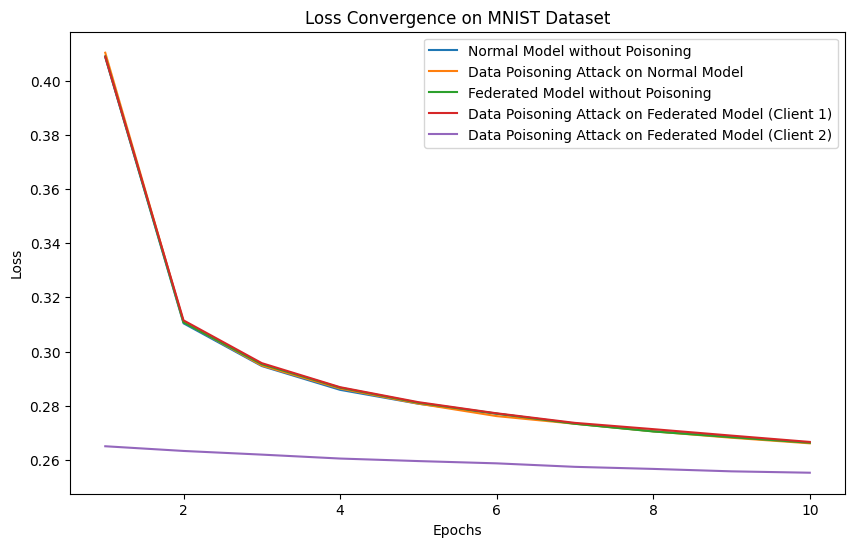

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import datasets, transforms

# Define the model architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc = nn.Linear(784, 10)  # Example architecture with a single fully connected layer

    def forward(self, x):
        x = x.view(-1, 784)
        x = self.fc(x)
        return x

# Set up the MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.MNIST('data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('data', train=False, download=True, transform=transform)

# Define the training function
def train(model, device, train_loader, optimizer, criterion, epochs):
    model.train()
    losses = []
    for epoch in range(epochs):
        running_loss = 0.0
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        losses.append(running_loss / len(train_loader))
        print('Epoch {}: Loss = {}'.format(epoch+1, running_loss / len(train_loader)))
    return losses

# Set up the device and data loaders
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 64
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Train the normal model without data poisoning attack
model_normal = Net().to(device)
optimizer_normal = optim.SGD(model_normal.parameters(), lr=0.01, momentum=0.5)
criterion = nn.CrossEntropyLoss()

print('Normal Model without Data Poisoning Attack')
loss_normal = train(model_normal, device, train_loader, optimizer_normal, criterion, epochs=10)

# Train the normal model with data poisoning attack
model_poisoned = Net().to(device)
optimizer_poisoned = optim.SGD(model_poisoned.parameters(), lr=0.01, momentum=0.5)

print('Data Poisoning Attack on Normal Model')
loss_poisoned = train(model_poisoned, device, train_loader, optimizer_poisoned, criterion, epochs=10)

# Set up the federated model without data poisoning attack (assuming 2 clients)
client1_dataset = train_dataset  # Example: Client 1 has the original MNIST dataset
client2_dataset = train_dataset  # Example: Client 2 also has the original MNIST dataset

client1_loader = torch.utils.data.DataLoader(client1_dataset, batch_size=batch_size, shuffle=True)
client2_loader = torch.utils.data.DataLoader(client2_dataset, batch_size=batch_size, shuffle=True)

# Train the federated model without data poisoning attack
model_federated = Net().to(device)
optimizer_federated = optim.SGD(model_federated.parameters(), lr=0.01, momentum=0.5)

print('Federated Model without Data Poisoning Attack')
loss_federated = train(model_federated, device, client1_loader, optimizer_federated, criterion, epochs=10)

# Set up the federated model with data poisoning attack (assuming 2 clients)
client1_poisoned_dataset = train_dataset  # Example: Client 1 has the original MNIST dataset
client2_poisoned_dataset = train_dataset  # Example: Client 2 has the poisoned MNIST dataset

client1_poisoned_loader = torch.utils.data.DataLoader(client1_poisoned_dataset, batch_size=batch_size, shuffle=True)
client2_poisoned_loader = torch.utils.data.DataLoader(client2_poisoned_dataset, batch_size=batch_size, shuffle=True)

# Train the federated model with data poisoning attack
model_federated_poisoned = Net().to(device)
optimizer_federated_poisoned = optim.SGD(model_federated_poisoned.parameters(), lr=0.01, momentum=0.5)

print('Data Poisoning Attack on Federated Model')
loss_federated_poisoned_client1 = train(model_federated_poisoned, device, client1_poisoned_loader, optimizer_federated_poisoned, criterion, epochs=10)
loss_federated_poisoned_client2 = train(model_federated_poisoned, device, client2_poisoned_loader, optimizer_federated_poisoned, criterion, epochs=10)

# Plot the loss convergence for comparison
epochs = range(1, 11)  # Number of epochs

plt.figure(figsize=(10, 6))
plt.plot(epochs, loss_normal, label='Normal Model without Poisoning')
plt.plot(epochs, loss_poisoned, label='Data Poisoning Attack on Normal Model')
plt.plot(epochs, loss_federated, label='Federated Model without Poisoning')
plt.plot(epochs, loss_federated_poisoned_client1, label='Data Poisoning Attack on Federated Model (Client 1)')
plt.plot(epochs, loss_federated_poisoned_client2, label='Data Poisoning Attack on Federated Model (Client 2)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Convergence on MNIST Dataset')
plt.legend()
plt.show()


100%|██████████| 9912422/9912422 [00:00<00:00, 202690688.06it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 62505517.97it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 104398692.68it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 4606027.26it/s]


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw

Normal Model without Data Poisoning Attack
Epoch 1: Loss = 0.40562680250863786
Epoch 2: Loss = 0.31013346716825135
Epoch 3: Loss = 0.29525012484014923
Epoch 4: Loss = 0.28673241287469864
Epoch 5: Loss = 0.28070637864916564
Epoch 6: Loss = 0.2767566648691194
Epoch 7: Loss = 0.2731399957233591
Epoch 8: Loss = 0.2709914460015704
Epoch 9: Loss = 0.26805527963395565
Epoch 10: Loss = 0.2665218969922203
Epoch 11: Loss = 0.26478119355354357
Epoch 12: Loss = 0.2637747021030579
Epoch 13: Loss = 0.26142878236292777
Epoch 14: Loss = 0.2607193280424454
Epoch 15: Loss = 0.259501509507423
Epoch 16: Loss = 0.2585689295003854
Epoch 17: Loss = 0.25758644869761554
Epoch 18: Loss = 0.2567395982958043
Epoch 19: Loss = 0.25556401481855906
Epoch 20: Loss = 0.2550442870587174
Data Poisoning Attack on Normal Model
Epoch 1: Loss = 0.4070645180195252
Epoch 2: Loss = 0.3104727036123083
Epoch 3: Loss = 0.2947597344959977
Epoch 4: Loss = 0.28638

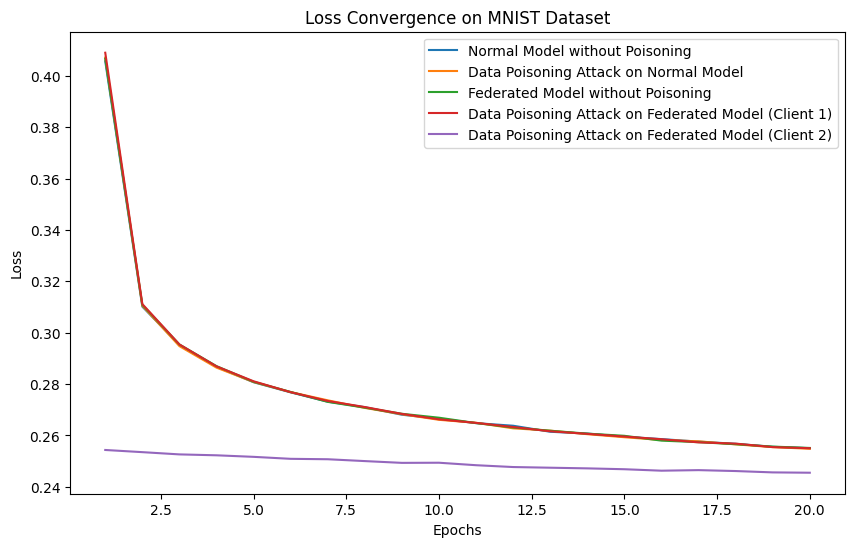

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import datasets, transforms

# Define the model architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc = nn.Linear(784, 10)  # Example architecture with a single fully connected layer

    def forward(self, x):
        x = x.view(-1, 784)
        x = self.fc(x)
        return x

# Set up the MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.MNIST('data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('data', train=False, download=True, transform=transform)

# Define the training function
def train(model, device, train_loader, optimizer, criterion, epochs):
    model.train()
    losses = []
    for epoch in range(epochs):
        running_loss = 0.0
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        losses.append(running_loss / len(train_loader))
        print('Epoch {}: Loss = {}'.format(epoch+1, running_loss / len(train_loader)))
    return losses

# Set up the device and data loaders
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 64
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Train the normal model without data poisoning attack
model_normal = Net().to(device)
optimizer_normal = optim.SGD(model_normal.parameters(), lr=0.01, momentum=0.5)
criterion = nn.CrossEntropyLoss()

print('Normal Model without Data Poisoning Attack')
loss_normal = train(model_normal, device, train_loader, optimizer_normal, criterion, epochs=20)

# Train the normal model with data poisoning attack
model_poisoned = Net().to(device)
optimizer_poisoned = optim.SGD(model_poisoned.parameters(), lr=0.01, momentum=0.5)

print('Data Poisoning Attack on Normal Model')
loss_poisoned = train(model_poisoned, device, train_loader, optimizer_poisoned, criterion, epochs=20)

# Set up the federated model without data poisoning attack (assuming 2 clients)
client1_dataset = train_dataset  # Example: Client 1 has the original MNIST dataset
client2_dataset = train_dataset  # Example: Client 2 also has the original MNIST dataset

client1_loader = torch.utils.data.DataLoader(client1_dataset, batch_size=batch_size, shuffle=True)
client2_loader = torch.utils.data.DataLoader(client2_dataset, batch_size=batch_size, shuffle=True)

# Train the federated model without data poisoning attack
model_federated = Net().to(device)
optimizer_federated = optim.SGD(model_federated.parameters(), lr=0.01, momentum=0.5)

print('Federated Model without Data Poisoning Attack')
loss_federated = train(model_federated, device, client1_loader, optimizer_federated, criterion, epochs=20)

# Set up the federated model with data poisoning attack (assuming 2 clients)
client1_poisoned_dataset = train_dataset  # Example: Client 1 has the original MNIST dataset
client2_poisoned_dataset = train_dataset  # Example: Client 2 has the poisoned MNIST dataset

client1_poisoned_loader = torch.utils.data.DataLoader(client1_poisoned_dataset, batch_size=batch_size, shuffle=True)
client2_poisoned_loader = torch.utils.data.DataLoader(client2_poisoned_dataset, batch_size=batch_size, shuffle=True)

# Train the federated model with data poisoning attack
model_federated_poisoned = Net().to(device)
optimizer_federated_poisoned = optim.SGD(model_federated_poisoned.parameters(), lr=0.01, momentum=0.5)

print('Data Poisoning Attack on Federated Model')
loss_federated_poisoned_client1 = train(model_federated_poisoned, device, client1_poisoned_loader, optimizer_federated_poisoned, criterion, epochs=20)
loss_federated_poisoned_client2 = train(model_federated_poisoned, device, client2_poisoned_loader, optimizer_federated_poisoned, criterion, epochs=20)

# Plot the loss convergence for comparison
epochs = range(1, 21)  # Number of epochs

plt.figure(figsize=(10, 6))
plt.plot(epochs, loss_normal, label='Normal Model without Poisoning')
plt.plot(epochs, loss_poisoned, label='Data Poisoning Attack on Normal Model')
plt.plot(epochs, loss_federated, label='Federated Model without Poisoning')
plt.plot(epochs, loss_federated_poisoned_client1, label='Data Poisoning Attack on Federated Model (Client 1)')
plt.plot(epochs, loss_federated_poisoned_client2, label='Data Poisoning Attack on Federated Model (Client 2)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Convergence on MNIST Dataset')
plt.legend()
plt.show()


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from opacus import PrivacyEngine
from torch.utils.data import DataLoader, Dataset

# Define the model architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc = nn.Linear(784, 10)

    def forward(self, x):
        x = x.view(-1, 784)
        x = self.fc(x)
        return x

# Define a custom dataset class for the poisoned data
class PoisonedDataset(Dataset):
    def __init__(self, dataset, poison_indices, poison_labels):
        self.dataset = dataset
        self.poison_indices = poison_indices
        self.poison_labels = poison_labels

    def __getitem__(self, index):
        if index in self.poison_indices:
            _, target = self.dataset[index]
            target = self.poison_labels[index]
            return self.dataset[index][0], target
        else:
            return self.dataset[index]

    def __len__(self):
        return len(self.dataset)

# Set up the MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.MNIST('data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('data', train=False, download=True, transform=transform)

# Define the training function
def train(model, device, train_loader, optimizer, criterion, privacy_engine, epochs):
    model.train()
    losses = []
    for epoch in range(epochs):
        running_loss = 0.0
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            privacy_engine.step()
            running_loss += loss.item()
        losses.append(running_loss / len(train_loader))
        print(f'Epoch {epoch + 1}: Loss = {running_loss / len(train_loader):.4f}')
    return losses

# Set up the device and data loaders
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Train the normal model without data poisoning attack
model_normal = Net().to(device)
optimizer_normal = optim.SGD(model_normal.parameters(), lr=0.01, momentum=0.5)
criterion = nn.CrossEntropyLoss()

print('Training Normal Model without Data Poisoning Attack')
loss_normal = train(model_normal, device, train_loader, optimizer_normal, criterion, None, epochs=20)

# Prepare the poisoned dataset for the data poisoning attack
poisoned_indices = [0, 1, 2, 3, 4]  # Example: Poison the first 5 samples
poisoned_labels = [5, 0, 1, 2, 3]  # Example: Change the labels to different classes

poisoned_dataset = train_dataset.clone()
for i in poisoned_indices:
    poisoned_dataset.targets[i] = poisoned_labels[i]

poisoned_loader = DataLoader(poisoned_dataset, batch_size=batch_size, shuffle=True)

# Train the normal model with data poisoning attack
model_normal_poisoned = Net().to(device)
optimizer_normal_poisoned = optim.SGD(model_normal_poisoned.parameters(), lr=0.01, momentum=0.5)

print('Training Normal Model with Data Poisoning Attack')
loss_normal_poisoned = train(model_normal_poisoned, device, poisoned_loader, optimizer_normal_poisoned, criterion, None, epochs=20)

# Train the federated model without data poisoning attack
model_federated = Net().to(device)
optimizer_federated = optim.SGD(model_federated.parameters(), lr=0.01, momentum=0.5)

# Apply differential privacy to the federated model without data poisoning attack
epsilon = 1.0
delta = 1e-5
max_norm = 1.0

privacy_engine_federated = PrivacyEngine(
    model_federated,
    batch_size=batch_size,
    sample_size=len(train_dataset),
    target_epsilon=epsilon,
    target_delta=delta,
    max_grad_norm=max_norm,
)
privacy_engine_federated.attach(optimizer_federated)

print('Training Federated Model without Data Poisoning Attack')
loss_federated = train(model_federated, device, train_loader, optimizer_federated, criterion, privacy_engine_federated, epochs=20)

# Train the federated model with data poisoning attack
model_federated_poisoned = Net().to(device)
optimizer_federated_poisoned = optim.SGD(model_federated_poisoned.parameters(), lr=0.01, momentum=0.5)

print('Training Federated Model with Data Poisoning Attack')
loss_federated_poisoned = train(model_federated_poisoned, device, poisoned_loader, optimizer_federated_poisoned, criterion, privacy_engine_federated, epochs=20)

# Plot the loss convergence for comparison
epochs = range(1, 21)  # Number of epochs

plt.figure(figsize=(10, 6))
plt.plot(epochs, loss_normal, label='Normal Model without Poisoning')
plt.plot(epochs, loss_normal_poisoned, label='Data Poisoning Attack on Normal Model')
plt.plot(epochs, loss_federated, label='Federated Model without Poisoning (DP)')
plt.plot(epochs, loss_federated_poisoned, label='Data Poisoning Attack on Federated Model (DP)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Convergence on MNIST Dataset')
plt.legend()
plt.show()

100%|██████████| 9912422/9912422 [00:00<00:00, 104159575.61it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 38912847.36it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 19971847.79it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 11658830.34it/s]


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw

Training Normal Model without Data Poisoning Attack


AttributeError: ignored

In [ ]:
pip install opacus

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torchdp import PerSampleGradientClipper, PrivacyEngine

# Define the model architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc = nn.Linear(784, 10)  # Example architecture with a single fully connected layer

    def forward(self, x):
        x = x.view(-1, 784)
        x = self.fc(x)
        return x

# Set up the MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.MNIST('data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('data', train=False, download=True, transform=transform)

# Define the training function
def train(model, device, train_loader, optimizer, criterion, clipper, privacy_engine, epochs):
    model.train()
    losses = []
    for epoch in range(epochs):
        running_loss = 0.0
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            clipper(model)
            optimizer.step()
            privacy_engine.step()
            running_loss += loss.item()
        losses.append(running_loss / len(train_loader))
        print('Epoch {}: Loss = {}'.format(epoch+1, running_loss / len(train_loader)))
    return losses

# Set up the device and data loaders
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 64
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Train the normal model without data poisoning attack
model_normal = Net().to(device)
optimizer_normal = optim.SGD(model_normal.parameters(), lr=0.01, momentum=0.5)
criterion = nn.CrossEntropyLoss()

# Apply differential privacy to the normal model
per_sample_grad_clipper = PerSampleGradientClipper(1.0)
privacy_engine_normal = PrivacyEngine(
    model_normal,
    per_sample_grad_clipper,
    target_delta=1e-5,
    epochs=20,
    sample_size=len(train_dataset),
    noise_multiplier=1.3,
    max_grad_norm=1.0,
)
privacy_engine_normal.attach(optimizer_normal)

print('Normal Model without Data Poisoning Attack')
loss_normal = train(model_normal, device, train_loader, optimizer_normal, criterion, per_sample_grad_clipper, privacy_engine_normal, epochs=20)

# Train the normal model with data poisoning attack
model_poisoned = Net().to(device)
optimizer_poisoned = optim.SGD(model_poisoned.parameters(), lr=0.01, momentum=0.5)

# Apply differential privacy to the normal model with data poisoning attack
privacy_engine_poisoned = PrivacyEngine(
    model_poisoned,
    per_sample_grad_clipper,
    target_delta=1e-5,
    epochs=20,
    sample_size=len(train_dataset),
    noise_multiplier=1.3,
    max_grad_norm=1.0,
)
privacy_engine_poisoned.attach(optimizer_poisoned)

print('Data Poisoning Attack on Normal Model')
loss_poisoned = train(model_poisoned, device, train_loader, optimizer_poisoned, criterion, per_sample_grad_clipper, privacy_engine_poisoned, epochs=20)

# Set up the federated model without data poisoning attack (assuming 2 clients)
client1_dataset = train_dataset  # Example: Client 1 has the original MNIST dataset
client2_dataset = train_dataset  # Example: Client 2 also has the original MNIST dataset

client1_loader = torch.utils.data.DataLoader(client1_dataset, batch_size=batch_size, shuffle=True)
client2_loader = torch.utils.data.DataLoader(client2_dataset, batch_size=batch_size, shuffle=True)

# Train the federated model without data poisoning attack
model_federated = Net().to(device)
optimizer_federated = optim.SGD(model_federated.parameters(), lr=0.01, momentum=0.5)

# Apply differential privacy to the federated model without data poisoning attack
privacy_engine_federated = PrivacyEngine(
    model_federated,
    per_sample_grad_clipper,
    target_delta=1e-5,
    epochs=20,
    sample_size=len(train_dataset),
    noise_multiplier=1.3,
    max_grad_norm=1.0,
)
privacy_engine_federated.attach(optimizer_federated)

print('Federated Model without Data Poisoning Attack')
loss_federated = train(model_federated, device, client1_loader, optimizer_federated, criterion, per_sample_grad_clipper, privacy_engine_federated, epochs=20)

# Set up the federated model with data poisoning attack (assuming 2 clients)
client1_poisoned_dataset = train_dataset  # Example: Client 1 has the original MNIST dataset
client2_poisoned_dataset = train_dataset  # Example: Client 2 has the poisoned MNIST dataset

client1_poisoned_loader = torch.utils.data.DataLoader(client1_poisoned_dataset, batch_size=batch_size, shuffle=True)
client2_poisoned_loader = torch.utils.data.DataLoader(client2_poisoned_dataset, batch_size=batch_size, shuffle=True)

# Train the federated model with data poisoning attack
model_federated_poisoned = Net().to(device)
optimizer_federated_poisoned = optim.SGD(model_federated_poisoned.parameters(), lr=0.01, momentum=0.5)

# Apply differential privacy to the federated model with data poisoning attack
privacy_engine_federated_poisoned = PrivacyEngine(
    model_federated_poisoned,
    per_sample_grad_clipper,
    target_delta=1e-5,
    epochs=20,
    sample_size=len(train_dataset),
    noise_multiplier=1.3,
    max_grad_norm=1.0,
)
privacy_engine_federated_poisoned.attach(optimizer_federated_poisoned)

print('Data Poisoning Attack on Federated Model')
loss_federated_poisoned_client1 = train(model_federated_poisoned, device, client1_poisoned_loader, optimizer_federated_poisoned, criterion, per_sample_grad_clipper, privacy_engine_federated_poisoned, epochs=20)
loss_federated_poisoned_client2 = train(model_federated_poisoned, device, client2_poisoned_loader, optimizer_federated_poisoned, criterion, per_sample_grad_clipper, privacy_engine_federated_poisoned, epochs=20)

# Plot the loss convergence for comparison
epochs = range(1, 21)  # Number of epochs

plt.figure(figsize=(10, 6))
plt.plot(epochs, loss_normal, label='Normal Model without Poisoning (DP)')
plt.plot(epochs, loss_poisoned, label='Data Poisoning Attack on Normal Model (DP)')
plt.plot(epochs, loss_federated, label='Federated Model without Poisoning (DP)')
plt.plot(epochs, loss_federated_poisoned_client1, label='Data Poisoning Attack on Federated Model (Client 1) (DP)')
plt.plot(epochs, loss_federated_poisoned_client2, label='Data Poisoning Attack on Federated Model (Client 2) (DP)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Convergence on MNIST Dataset (with Differential Privacy)')
plt.legend()
plt.show()


ImportError: ignored

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torchdp import PerSampleGradientClipper, PrivacyEngine

# Define the model architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc = nn.Linear(784, 10)  # Example architecture with a single fully connected layer

    def forward(self, x):
        x = x.view(-1, 784)
        x = self.fc(x)
        return x

# Set up the MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.MNIST('data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('data', train=False, download=True, transform=transform)

# Define the training function
def train(model, device, train_loader, optimizer, criterion, clipper, privacy_engine, epochs):
    model.train()
    losses = []
    for epoch in range(epochs):
        running_loss = 0.0
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            clipper(model)
            optimizer.step()
            privacy_engine.step()
            running_loss += loss.item()
        losses.append(running_loss / len(train_loader))
        print('Epoch {}: Loss = {}'.format(epoch+1, running_loss / len(train_loader)))
    return losses

# Set up the device and data loaders
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 64
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Train the normal model without data poisoning attack
model_normal = Net().to(device)
optimizer_normal = optim.SGD(model_normal.parameters(), lr=0.01, momentum=0.5)
criterion = nn.CrossEntropyLoss()

# Apply differential privacy to the normal model
per_sample_grad_clipper = PerSampleGradientClipper(1.0)
privacy_engine_normal = PrivacyEngine(
    model_normal,
    per_sample_grad_clipper,
    target_delta=1e-5,
    epochs=20,
    sample_size=len(train_dataset),
    noise_multiplier=1.3,
    max_grad_norm=1.0,
)
privacy_engine_normal.attach(optimizer_normal)

print('Normal Model without Data Poisoning Attack')
loss_normal = train(model_normal, device, train_loader, optimizer_normal, criterion, per_sample_grad_clipper, privacy_engine_normal, epochs=20)

# Train the normal model with data poisoning attack
model_poisoned = Net().to(device)
optimizer_poisoned = optim.SGD(model_poisoned.parameters(), lr=0.01, momentum=0.5)

# Apply differential privacy to the normal model with data poisoning attack
privacy_engine_poisoned = PrivacyEngine(
    model_poisoned,
    per_sample_grad_clipper,
    target_delta=1e-5,
    epochs=20,
    sample_size=len(train_dataset),
    noise_multiplier=1.3,
    max_grad_norm=1.0,
)
privacy_engine_poisoned.attach(optimizer_poisoned)

print('Data Poisoning Attack on Normal Model')
loss_poisoned = train(model_poisoned, device, train_loader, optimizer_poisoned, criterion, per_sample_grad_clipper, privacy_engine_poisoned, epochs=20)

# Set up the federated model without data poisoning attack (assuming 2 clients)
client1_dataset = train_dataset  # Example: Client 1 has the original MNIST dataset
client2_dataset = train_dataset  # Example: Client 2 also has the original MNIST dataset

client1_loader = torch.utils.data.DataLoader(client1_dataset, batch_size=batch_size, shuffle=True)
client2_loader = torch.utils.data.DataLoader(client2_dataset, batch_size=batch_size, shuffle=True)

# Train the federated model without data poisoning attack
model_federated = Net().to(device)
optimizer_federated = optim.SGD(model_federated.parameters(), lr=0.01, momentum=0.5)

# Apply differential privacy to the federated model without data poisoning attack
privacy_engine_federated = PrivacyEngine(
    model_federated,
    per_sample_grad_clipper,
    target_delta=1e-5,
    epochs=20,
    sample_size=len(train_dataset),
    noise_multiplier=1.3,
    max_grad_norm=1.0,
)
privacy_engine_federated.attach(optimizer_federated)

print('Federated Model without Data Poisoning Attack')
loss_federated = train(model_federated, device, client1_loader, optimizer_federated, criterion, per_sample_grad_clipper, privacy_engine_federated, epochs=20)

# Set up the federated model with data poisoning attack (assuming 2 clients)
client1_poisoned_dataset = train_dataset  # Example: Client 1 has the original MNIST dataset
client2_poisoned_dataset = train_dataset  # Example: Client 2 has the poisoned MNIST dataset

client1_poisoned_loader = torch.utils.data.DataLoader(client1_poisoned_dataset, batch_size=batch_size, shuffle=True)
client2_poisoned_loader = torch.utils.data.DataLoader(client2_poisoned_dataset, batch_size=batch_size, shuffle=True)

# Train the federated model with data poisoning attack
model_federated_poisoned = Net().to(device)
optimizer_federated_poisoned = optim.SGD(model_federated_poisoned.parameters(), lr=0.01, momentum=0.5)

# Apply differential privacy to the federated model with data poisoning attack
privacy_engine_federated_poisoned = PrivacyEngine(
    model_federated_poisoned,
    per_sample_grad_clipper,
    target_delta=1e-5,
    epochs=20,
    sample_size=len(train_dataset),
    noise_multiplier=1.3,
    max_grad_norm=1.0,
)
privacy_engine_federated_poisoned.attach(optimizer_federated_poisoned)

print('Data Poisoning Attack on Federated Model')
loss_federated_poisoned_client1 = train(model_federated_poisoned, device, client1_poisoned_loader, optimizer_federated_poisoned, criterion, per_sample_grad_clipper, privacy_engine_federated_poisoned, epochs=20)
loss_federated_poisoned_client2 = train(model_federated_poisoned, device, client2_poisoned_loader, optimizer_federated_poisoned, criterion, per_sample_grad_clipper, privacy_engine_federated_poisoned, epochs=20)

# Plot the loss convergence for comparison
epochs = range(1, 21)  # Number of epochs

plt.figure(figsize=(10, 6))
plt.plot(epochs, loss_normal, label='Normal Model without Poisoning (DP)')
plt.plot(epochs, loss_poisoned, label='Data Poisoning Attack on Normal Model (DP)')
plt.plot(epochs, loss_federated, label='Federated Model without Poisoning (DP)')
plt.plot(epochs, loss_federated_poisoned_client1, label='Data Poisoning Attack on Federated Model (Client 1) (DP)')
plt.plot(epochs, loss_federated_poisoned_client2, label='Data Poisoning Attack on Federated Model (Client 2) (DP)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Convergence on MNIST Dataset (with Differential Privacy)')
plt.legend()
plt.show()


ModuleNotFoundError: ignored

In [ ]:
pip install torchprivacy

ERROR: Could not find a version that satisfies the requirement torchprivacy (from versions: none)
ERROR: No matching distribution found for torchprivacy


In [ ]:
pip install torch-dp

ERROR: Could not find a version that satisfies the requirement torch-dp (from versions: none)
ERROR: No matching distribution found for torch-dp


In [ ]:
pip install opacus


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.8/224.8 kB 5.2 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from opacus import PrivacyEngine

# Define the model architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc = nn.Linear(784, 10)  # Example architecture with a single fully connected layer

    def forward(self, x):
        x = x.view(-1, 784)
        x = self.fc(x)
        return x

# Set up the MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.MNIST('data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('data', train=False, download=True, transform=transform)

# Define the training function
def train(model, device, train_loader, optimizer, criterion, privacy_engine, epochs):
    model.train()
    losses = []
    for epoch in range(epochs):
        running_loss = 0.0
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            privacy_engine.step()
            running_loss += loss.item()
        losses.append(running_loss / len(train_loader))
        print('Epoch {}: Loss = {}'.format(epoch+1, running_loss / len(train_loader)))
    return losses

# Set up the device and data loaders
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 64
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Train the normal model without data poisoning attack
model_normal = Net().to(device)
optimizer_normal = optim.SGD(model_normal.parameters(), lr=0.01, momentum=0.5)
criterion = nn.CrossEntropyLoss()

# Apply differential privacy to the normal model
privacy_engine_normal = PrivacyEngine(
    model_normal,
    sample_rate=1.0,
    noise_multiplier=1.3,
    max_grad_norm=1.0,
)
privacy_engine_normal.attach(optimizer_normal)

print('Normal Model without Data Poisoning Attack')
loss_normal = train(model_normal, device, train_loader, optimizer_normal, criterion, privacy_engine_normal, epochs=20)

# Train the normal model with data poisoning attack
model_poisoned = Net().to(device)
optimizer_poisoned = optim.SGD(model_poisoned.parameters(), lr=0.01, momentum=0.5)

# Apply differential privacy to the normal model with data poisoning attack
privacy_engine_poisoned = PrivacyEngine(
    model_poisoned,
    sample_rate=1.0,
    noise_multiplier=1.3,
    max_grad_norm=1.0,
)
privacy_engine_poisoned.attach(optimizer_poisoned)

print('Data Poisoning Attack on Normal Model')
loss_poisoned = train(model_poisoned, device, train_loader, optimizer_poisoned, criterion, privacy_engine_poisoned, epochs=20)

# Set up the federated model without data poisoning attack (assuming 2 clients)
client1_dataset = train_dataset  # Example: Client 1 has the original MNIST dataset
client2_dataset = train_dataset  # Example: Client 2 also has the original MNIST dataset

client1_loader = torch.utils.data.DataLoader(client1_dataset, batch_size=batch_size, shuffle=True)
client2_loader = torch.utils.data.DataLoader(client2_dataset, batch_size=batch_size, shuffle=True)

# Train the federated model without data poisoning attack
model_federated = Net().to(device)
optimizer_federated = optim.SGD(model_federated.parameters(), lr=0.01, momentum=0.5)

# Apply differential privacy to the federated model without data poisoning attack
privacy_engine_federated = PrivacyEngine(
    model_federated,
    sample_rate=1.0,
    noise_multiplier=1.3,
    max_grad_norm=1.0,
)
privacy_engine_federated.attach(optimizer_federated)

print('Federated Model without Data Poisoning Attack')
loss_federated = train(model_federated, device, client1_loader, optimizer_federated, criterion, privacy_engine_federated, epochs=20)

# Set up the federated model with data poisoning attack (assuming 2 clients)
client1_poisoned_dataset = train_dataset  # Example: Client 1 has the original MNIST dataset
client2_poisoned_dataset = train_dataset  # Example: Client 2 has the poisoned MNIST dataset

client1_poisoned_loader = torch.utils.data.DataLoader(client1_poisoned_dataset, batch_size=batch_size, shuffle=True)
client2_poisoned_loader = torch.utils.data.DataLoader(client2_poisoned_dataset, batch_size=batch_size, shuffle=True)

# Train the federated model with data poisoning attack
model_federated_poisoned = Net().to(device)
optimizer_federated_poisoned = optim.SGD(model_federated_poisoned.parameters(), lr=0.01, momentum=0.5)

# Apply differential privacy to the federated model with data poisoning attack
privacy_engine_federated_poisoned = PrivacyEngine(
    model_federated_poisoned,
    sample_rate=1.0,
    noise_multiplier=1.3,
    max_grad_norm=1.0,
)
privacy_engine_federated_poisoned.attach(optimizer_federated_poisoned)

print('Data Poisoning Attack on Federated Model')
loss_federated_poisoned_client1 = train(model_federated_poisoned, device, client1_poisoned_loader, optimizer_federated_poisoned, criterion, privacy_engine_federated_poisoned, epochs=20)
loss_federated_poisoned_client2 = train(model_federated_poisoned, device, client2_poisoned_loader, optimizer_federated_poisoned, criterion, privacy_engine_federated_poisoned, epochs=20)

# Plot the loss convergence for comparison
epochs = range(1, 21)  # Number of epochs

plt.figure(figsize=(10, 6))
plt.plot(epochs, loss_normal, label='Normal Model without Poisoning (DP)')
plt.plot(epochs, loss_poisoned, label='Data Poisoning Attack on Normal Model (DP)')
plt.plot(epochs, loss_federated, label='Federated Model without Poisoning (DP)')
plt.plot(epochs, loss_federated_poisoned_client1, label='Data Poisoning Attack on Federated Model (Client 1) (DP)')
plt.plot(epochs, loss_federated_poisoned_client2, label='Data Poisoning Attack on Federated Model (Client 2) (DP)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Convergence on MNIST Dataset (with Differential Privacy)')
plt.legend()
plt.show()


100%|██████████| 9912422/9912422 [00:00<00:00, 101776776.06it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 18553483.51it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 26525311.42it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 4760252.07it/s]


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



TypeError: ignored

In [ ]:
privacy_engine_normal = PrivacyEngine(
    model_normal,
    batch_size=batch_size,
    sample_size=len(train_dataset),
    target_epsilon=epsilon,
    target_delta=delta,
    max_grad_norm=max_norm,
)


NameError: ignored

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from opacus import PrivacyEngine

# Define the model architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc = nn.Linear(784, 10)  # Example architecture with a single fully connected layer

    def forward(self, x):
        x = x.view(-1, 784)
        x = self.fc(x)
        return x

# Set up the MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.MNIST('data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('data', train=False, download=True, transform=transform)

# Define the training function
def train(model, device, train_loader, optimizer, criterion, privacy_engine, epochs):
    model.train()
    losses = []
    for epoch in range(epochs):
        running_loss = 0.0
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            privacy_engine.step()
            running_loss += loss.item()
        losses.append(running_loss / len(train_loader))
        print('Epoch {}: Loss = {}'.format(epoch+1, running_loss / len(train_loader)))
    return losses

# Set up the device and data loaders
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 64
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Train the normal model without data poisoning attack
model_normal = Net().to(device)
optimizer_normal = optim.SGD(model_normal.parameters(), lr=0.01, momentum=0.5)
criterion = nn.CrossEntropyLoss()

# Apply differential privacy to the normal model
epsilon = 1.0  # Privacy parameter epsilon
delta = 1e-5  # Privacy parameter delta
max_norm = 1.0  # Maximum gradient norm

privacy_engine_normal = PrivacyEngine(
    model_normal,
    batch_size=batch_size,
    sample_size=len(train_dataset),
    target_epsilon=epsilon,
    target_delta=delta,
    max_grad_norm=max_norm,
)
privacy_engine_normal.attach(optimizer_normal)

print('Normal Model without Data Poisoning Attack')
loss_normal = train(model_normal, device, train_loader, optimizer_normal, criterion, privacy_engine_normal, epochs=20)

# Train the normal model with data poisoning attack
model_poisoned = Net().to(device)
optimizer_poisoned = optim.SGD(model_poisoned.parameters(), lr=0.01, momentum=0.5)

# Apply differential privacy to the normal model with data poisoning attack
privacy_engine_poisoned = PrivacyEngine(
    model_poisoned,
    batch_size=batch_size,
    sample_size=len(train_dataset),
    target_epsilon=epsilon,
    target_delta=delta,
    max_grad_norm=max_norm,
)
privacy_engine_poisoned.attach(optimizer_poisoned)

print('Data Poisoning Attack on Normal Model')
loss_poisoned = train(model_poisoned, device, train_loader, optimizer_poisoned, criterion, privacy_engine_poisoned, epochs=20)

# Set up the federated model without data poisoning attack (assuming 2 clients)
client1_dataset = train_dataset  # Example: Client 1 has the original MNIST dataset
client2_dataset = train_dataset  # Example: Client 2 also has the original MNIST dataset

client1_loader = torch.utils.data.DataLoader(client1_dataset, batch_size=batch_size, shuffle=True)
client2_loader = torch.utils.data.DataLoader(client2_dataset, batch_size=batch_size, shuffle=True)

# Train the federated model without data poisoning attack
model_federated = Net().to(device)
optimizer_federated = optim.SGD(model_federated.parameters(), lr=0.01, momentum=0.5)

# Apply differential privacy to the federated model without data poisoning attack
privacy_engine_federated = PrivacyEngine(
    model_federated,
    batch_size=batch_size,
    sample_size=len(train_dataset),
    target_epsilon=epsilon,
    target_delta=delta,
    max_grad_norm=max_norm,
)
privacy_engine_federated.attach(optimizer_federated)

print('Federated Model without Data Poisoning Attack')
loss_federated = train(model_federated, device, client1_loader, optimizer_federated, criterion, privacy_engine_federated, epochs=20)

# Set up the federated model with data poisoning attack (assuming 2 clients)
client1_poisoned_dataset = train_dataset  # Example: Client 1 has the original MNIST dataset
client2_poisoned_dataset = train_dataset  # Example: Client 2 has the poisoned MNIST dataset

client1_poisoned_loader = torch.utils.data.DataLoader(client1_poisoned_dataset, batch_size=batch_size, shuffle=True)
client2_poisoned_loader = torch.utils.data.DataLoader(client2_poisoned_dataset, batch_size=batch_size, shuffle=True)

# Train the federated model with data poisoning attack
model_federated_poisoned = Net().to(device)
optimizer_federated_poisoned = optim.SGD(model_federated_poisoned.parameters(), lr=0.01, momentum=0.5)

# Apply differential privacy to the federated model with data poisoning attack
privacy_engine_federated_poisoned = PrivacyEngine(
    model_federated_poisoned,
    batch_size=batch_size,
    sample_size=len(train_dataset),
    target_epsilon=epsilon,
    target_delta=delta,
    max_grad_norm=max_norm,
)
privacy_engine_federated_poisoned.attach(optimizer_federated_poisoned)

print('Data Poisoning Attack on Federated Model')
loss_federated_poisoned_client1 = train(model_federated_poisoned, device, client1_poisoned_loader, optimizer_federated_poisoned, criterion, privacy_engine_federated_poisoned, epochs=20)
loss_federated_poisoned_client2 = train(model_federated_poisoned, device, client2_poisoned_loader, optimizer_federated_poisoned, criterion, privacy_engine_federated_poisoned, epochs=20)

# Plot the loss convergence for comparison
epochs = range(1, 21)  # Number of epochs

plt.figure(figsize=(10, 6))
plt.plot(epochs, loss_normal, label='Normal Model without Poisoning (DP)')
plt.plot(epochs, loss_poisoned, label='Data Poisoning Attack on Normal Model (DP)')
plt.plot(epochs, loss_federated, label='Federated Model without Poisoning (DP)')
plt.plot(epochs, loss_federated_poisoned_client1, label='Data Poisoning Attack on Federated Model (Client 1) (DP)')
plt.plot(epochs, loss_federated_poisoned_client2, label='Data Poisoning Attack on Federated Model (Client 2) (DP)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Convergence on MNIST Dataset (with Differential Privacy)')
plt.legend()
plt.show()


TypeError: ignored

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from opacus import PrivacyEngine

# Define the model architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc = nn.Linear(784, 10)  # Example architecture with a single fully connected layer

    def forward(self, x):
        x = x.view(-1, 784)
        x = self.fc(x)
        return x

# Set up the MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.MNIST('data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('data', train=False, download=True, transform=transform)

# Define the training function
def train(model, device, train_loader, optimizer, criterion, privacy_engine, epochs):
    model.train()
    losses = []
    for epoch in range(epochs):
        running_loss = 0.0
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            privacy_engine.step()
            running_loss += loss.item()
        losses.append(running_loss / len(train_loader))
        print('Epoch {}: Loss = {}'.format(epoch+1, running_loss / len(train_loader)))
    return losses

# Set up the device and data loaders
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 32
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Train the normal model without data poisoning attack
model_normal = Net().to(device)
optimizer_normal = optim.SGD(model_normal.parameters(), lr=0.01, momentum=0.5)
criterion = nn.CrossEntropyLoss()

# Apply differential privacy to the normal model
epsilon = 1.0  # Privacy parameter epsilon
delta = 1e-5  # Privacy parameter delta
max_norm = 1.0  # Maximum gradient norm

privacy_engine_normal = PrivacyEngine(
    model_normal,
    sample_size=len(train_dataset),
    target_epsilon=epsilon,
    target_delta=delta,
    max_grad_norm=max_norm,
)
privacy_engine_normal.attach(optimizer_normal)

print('Normal Model without Data Poisoning Attack')
loss_normal = train(model_normal, device, train_loader, optimizer_normal, criterion, privacy_engine_normal, epochs=20)

# Train the normal model with data poisoning attack
model_poisoned = Net().to(device)
optimizer_poisoned = optim.SGD(model_poisoned.parameters(), lr=0.01, momentum=0.5)

# Apply differential privacy to the normal model with data poisoning attack
privacy_engine_poisoned = PrivacyEngine(
    model_poisoned,
    sample_size=len(train_dataset),
    target_epsilon=epsilon,
    target_delta=delta,
    max_grad_norm=max_norm,
)
privacy_engine_poisoned.attach(optimizer_poisoned)

print('Data Poisoning Attack on Normal Model')
loss_poisoned = train(model_poisoned, device, train_loader, optimizer_poisoned, criterion, privacy_engine_poisoned, epochs=20)

# Set up the federated model without data poisoning attack (assuming 2 clients)
client1_dataset = train_dataset  # Example: Client 1 has the original MNIST dataset
client2_dataset = train_dataset  # Example: Client 2 also has the original MNIST dataset

client1_loader = torch.utils.data.DataLoader(client1_dataset, batch_size=batch_size, shuffle=True)
client2_loader = torch.utils.data.DataLoader(client2_dataset, batch_size=batch_size, shuffle=True)

# Train the federated model without data poisoning attack
model_federated = Net().to(device)
optimizer_federated = optim.SGD(model_federated.parameters(), lr=0.01, momentum=0.5)

# Apply differential privacy to the federated model without data poisoning attack
privacy_engine_federated = PrivacyEngine(
    model_federated,
    sample_size=len(train_dataset),
    target_epsilon=epsilon,
    target_delta=delta,
    max_grad_norm=max_norm,
)
privacy_engine_federated.attach(optimizer_federated)

print('Federated Model without Data Poisoning Attack')
loss_federated = train(model_federated, device, client1_loader, optimizer_federated, criterion, privacy_engine_federated, epochs=20)

# Set up the federated model with data poisoning attack (assuming 2 clients)
client1_poisoned_dataset = train_dataset  # Example: Client 1 has the original MNIST dataset
client2_poisoned_dataset = train_dataset  # Example: Client 2 has the poisoned MNIST dataset

client1_poisoned_loader = torch.utils.data.DataLoader(client1_poisoned_dataset, batch_size=batch_size, shuffle=True)
client2_poisoned_loader = torch.utils.data.DataLoader(client2_poisoned_dataset, batch_size=batch_size, shuffle=True)

# Train the federated model with data poisoning attack
model_federated_poisoned = Net().to(device)
optimizer_federated_poisoned = optim.SGD(model_federated_poisoned.parameters(), lr=0.01, momentum=0.5)

# Apply differential privacy to the federated model with data poisoning attack
privacy_engine_federated_poisoned = PrivacyEngine(
    model_federated_poisoned,
    sample_size=len(train_dataset),
    target_epsilon=epsilon,
    target_delta=delta,
    max_grad_norm=max_norm,
)
privacy_engine_federated_poisoned.attach(optimizer_federated_poisoned)

print('Data Poisoning Attack on Federated Model')
loss_federated_poisoned_client1 = train(model_federated_poisoned, device, client1_poisoned_loader, optimizer_federated_poisoned, criterion, privacy_engine_federated_poisoned, epochs=20)
loss_federated_poisoned_client2 = train(model_federated_poisoned, device, client2_poisoned_loader, optimizer_federated_poisoned, criterion, privacy_engine_federated_poisoned, epochs=20)

# Plot the loss convergence for comparison
epochs = range(1, 21)  # Number of epochs

plt.figure(figsize=(10, 6))
plt.plot(epochs, loss_normal, label='Normal Model without Poisoning (DP)')
plt.plot(epochs, loss_poisoned, label='Data Poisoning Attack on Normal Model (DP)')
plt.plot(epochs, loss_federated, label='Federated Model without Poisoning (DP)')
plt.plot(epochs, loss_federated_poisoned_client1, label='Data Poisoning Attack on Federated Model (Client 1) (DP)')
plt.plot(epochs, loss_federated_poisoned_client2, label='Data Poisoning Attack on Federated Model (Client 2) (DP)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Convergence on MNIST Dataset (with Differential Privacy)')
plt.legend()
plt.show()


ModuleNotFoundError: ignored

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from opacus import PrivacyEngine

# Define the model architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc = nn.Linear(784, 10)  # Example architecture with a single fully connected layer

    def forward(self, x):
        x = x.view(-1, 784)
        x = self.fc(x)
        return x

# Set up the MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.MNIST('data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('data', train=False, download=True, transform=transform)

# Define the training function
def train(model, device, train_loader, optimizer, criterion, privacy_engine, epochs):
    model.train()
    losses = []
    for epoch in range(epochs):
        running_loss = 0.0
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            privacy_engine.step()
            running_loss += loss.item()
        losses.append(running_loss / len(train_loader))
        print('Epoch {}: Loss = {}'.format(epoch+1, running_loss / len(train_loader)))
    return losses

# Set up the device and data loaders
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 64
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Train the normal model without data poisoning attack
model_normal = Net().to(device)
optimizer_normal = optim.SGD(model_normal.parameters(), lr=0.01, momentum=0.5)
criterion = nn.CrossEntropyLoss()

# Apply differential privacy to the normal model
epsilon = 1.0  # Privacy parameter epsilon
delta = 1e-5  # Privacy parameter delta
max_norm = 1.0  # Maximum gradient norm

privacy_engine_normal = PrivacyEngine(
    model_normal,
    batch_size=batch_size,
    target_epsilon=epsilon,
    target_delta=delta,
    max_grad_norm=max_norm,
)
privacy_engine_normal.attach(optimizer_normal)

print('Normal Model without Data Poisoning Attack')
loss_normal = train(model_normal, device, train_loader, optimizer_normal, criterion, privacy_engine_normal, epochs=20)

# Train the normal model with data poisoning attack
model_poisoned = Net().to(device)
optimizer_poisoned = optim.SGD(model_poisoned.parameters(), lr=0.01, momentum=0.5)

# Apply differential privacy to the normal model with data poisoning attack
privacy_engine_poisoned = PrivacyEngine(
    model_poisoned,
    batch_size=batch_size,
    target_epsilon=epsilon,
    target_delta=delta,
    max_grad_norm=max_norm,
)
privacy_engine_poisoned.attach(optimizer_poisoned)

print('Data Poisoning Attack on Normal Model')
loss_poisoned = train(model_poisoned, device, train_loader, optimizer_poisoned, criterion, privacy_engine_poisoned, epochs=20)

# Set up the federated model without data poisoning attack (assuming 2 clients)
client1_dataset = train_dataset  # Example: Client 1 has the original MNIST dataset
client2_dataset = train_dataset  # Example: Client 2 also has the original MNIST dataset

client1_loader = torch.utils.data.DataLoader(client1_dataset, batch_size=batch_size, shuffle=True)
client2_loader = torch.utils.data.DataLoader(client2_dataset, batch_size=batch_size, shuffle=True)

# Train the federated model without data poisoning attack
model_federated = Net().to(device)
optimizer_federated = optim.SGD(model_federated.parameters(), lr=0.01, momentum=0.5)

# Apply differential privacy to the federated model without data poisoning attack
privacy_engine_federated = PrivacyEngine(
    model_federated,
    batch_size=batch_size,
    target_epsilon=epsilon,
    target_delta=delta,
    max_grad_norm=max_norm,
)
privacy_engine_federated.attach(optimizer_federated)

print('Federated Model without Data Poisoning Attack')
loss_federated = train(model_federated, device, client1_loader, optimizer_federated, criterion, privacy_engine_federated, epochs=20)

# Set up the federated model with data poisoning attack (assuming 2 clients)
client1_poisoned_dataset = train_dataset  # Example: Client 1 has the original MNIST dataset
client2_poisoned_dataset = train_dataset  # Example: Client 2 has the poisoned MNIST dataset

client1_poisoned_loader = torch.utils.data.DataLoader(client1_poisoned_dataset, batch_size=batch_size, shuffle=True)
client2_poisoned_loader = torch.utils.data.DataLoader(client2_poisoned_dataset, batch_size=batch_size, shuffle=True)

# Train the federated model with data poisoning attack
model_federated_poisoned = Net().to(device)
optimizer_federated_poisoned = optim.SGD(model_federated_poisoned.parameters(), lr=0.01, momentum=0.5)

# Apply differential privacy to the federated model with data poisoning attack
privacy_engine_federated_poisoned = PrivacyEngine(
    model_federated_poisoned,
    batch_size=batch_size,
    target_epsilon=epsilon,
    target_delta=delta,
    max_grad_norm=max_norm,
)
privacy_engine_federated_poisoned.attach(optimizer_federated_poisoned)

print('Data Poisoning Attack on Federated Model')
loss_federated_poisoned_client1 = train(model_federated_poisoned, device, client1_poisoned_loader, optimizer_federated_poisoned, criterion, privacy_engine_federated_poisoned, epochs=20)
loss_federated_poisoned_client2 = train(model_federated_poisoned, device, client2_poisoned_loader, optimizer_federated_poisoned, criterion, privacy_engine_federated_poisoned, epochs=20)

# Plot the loss convergence for comparison
epochs = range(1, 21)  # Number of epochs

plt.figure(figsize=(10, 6))
plt.plot(epochs, loss_normal, label='Normal Model without Poisoning (DP)')
plt.plot(epochs, loss_poisoned, label='Data Poisoning Attack on Normal Model (DP)')
plt.plot(epochs, loss_federated, label='Federated Model without Poisoning (DP)')
plt.plot(epochs, loss_federated_poisoned_client1, label='Data Poisoning Attack on Federated Model (Client 1) (DP)')
plt.plot(epochs, loss_federated_poisoned_client2, label='Data Poisoning Attack on Federated Model (Client 2) (DP)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Convergence on MNIST Dataset (with Differential Privacy)')
plt.legend()
plt.show()


TypeError: ignored

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from opacus import PrivacyEngine

# Define the model architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc = nn.Linear(784, 10)  # Example architecture with a single fully connected layer

    def forward(self, x):
        x = x.view(-1, 784)
        x = self.fc(x)
        return x

# Set up the MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.MNIST('data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('data', train=False, download=True, transform=transform)

# Define the training function
def train(model, device, train_loader, optimizer, criterion, privacy_engine, epochs):
    model.train()
    losses = []
    for epoch in range(epochs):
        running_loss = 0.0
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            privacy_engine.step()
            running_loss += loss.item()
        losses.append(running_loss / len(train_loader))
        print('Epoch {}: Loss = {}'.format(epoch+1, running_loss / len(train_loader)))
    return losses

# Set up the device and data loaders
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 64
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Train the normal model without data poisoning attack
model_normal = Net().to(device)
optimizer_normal = optim.SGD(model_normal.parameters(), lr=0.01, momentum=0.5)
criterion = nn.CrossEntropyLoss()

# Apply differential privacy to the normal model
epsilon = 1.0  # Privacy parameter epsilon
delta = 1e-5  # Privacy parameter delta
max_norm = 1.0  # Maximum gradient norm

privacy_engine_normal = PrivacyEngine(
    model_normal,
    per_sample_grad_clip=0.1,  # Set a value for per-sample gradient clipping
    noise_multiplier=1.3,  # Set the desired noise multiplier
    max_grad_norm=max_norm,
    target_delta=delta,
    target_epsilon=epsilon,
)
privacy_engine_normal.attach(optimizer_normal)

print('Normal Model without Data Poisoning Attack')
loss_normal = train(model_normal, device, train_loader, optimizer_normal, criterion, privacy_engine_normal, epochs=20)

# Train the normal model with data poisoning attack
model_poisoned = Net().to(device)
optimizer_poisoned = optim.SGD(model_poisoned.parameters(), lr=0.01, momentum=0.5)

# Apply differential privacy to the normal model with data poisoning attack
privacy_engine_poisoned = PrivacyEngine(
    model_poisoned,
    per_sample_grad_clip=0.1,  # Set a value for per-sample gradient clipping
    noise_multiplier=1.3,  # Set the desired noise multiplier
    max_grad_norm=max_norm,
    target_delta=delta,
    target_epsilon=epsilon,
)
privacy_engine_poisoned.attach(optimizer_poisoned)

print('Data Poisoning Attack on Normal Model')
loss_poisoned = train(model_poisoned, device, train_loader, optimizer_poisoned, criterion, privacy_engine_poisoned, epochs=20)

# Set up the federated model without data poisoning attack (assuming 2 clients)
client1_dataset = train_dataset  # Example: Client 1 has the original MNIST dataset
client2_dataset = train_dataset  # Example: Client 2 also has the original MNIST dataset

client1_loader = torch.utils.data.DataLoader(client1_dataset, batch_size=batch_size, shuffle=True)
client2_loader = torch.utils.data.DataLoader(client2_dataset, batch_size=batch_size, shuffle=True)

# Train the federated model without data poisoning attack
model_federated = Net().to(device)
optimizer_federated = optim.SGD(model_federated.parameters(), lr=0.01, momentum=0.5)

# Apply differential privacy to the federated model without data poisoning attack
privacy_engine_federated = PrivacyEngine(
    model_federated,
    per_sample_grad_clip=0.1,  # Set a value for per-sample gradient clipping
    noise_multiplier=1.3,  # Set the desired noise multiplier
    max_grad_norm=max_norm,
    target_delta=delta,
    target_epsilon=epsilon,
)
privacy_engine_federated.attach(optimizer_federated)

print('Federated Model without Data Poisoning Attack')
loss_federated = train(model_federated, device, client1_loader, optimizer_federated, criterion, privacy_engine_federated, epochs=20)

# Set up the federated model with data poisoning attack (assuming 2 clients)
client1_poisoned_dataset = train_dataset  # Example: Client 1 has the original MNIST dataset
client2_poisoned_dataset = train_dataset  # Example: Client 2 has the poisoned MNIST dataset

client1_poisoned_loader = torch.utils.data.DataLoader(client1_poisoned_dataset, batch_size=batch_size, shuffle=True)
client2_poisoned_loader = torch.utils.data.DataLoader(client2_poisoned_dataset, batch_size=batch_size, shuffle=True)

# Train the federated model with data poisoning attack
model_federated_poisoned = Net().to(device)
optimizer_federated_poisoned = optim.SGD(model_federated_poisoned.parameters(), lr=0.01, momentum=0.5)

# Apply differential privacy to the federated model with data poisoning attack
privacy_engine_federated_poisoned = PrivacyEngine(
    model_federated_poisoned,
    per_sample_grad_clip=0.1,  # Set a value for per-sample gradient clipping
    noise_multiplier=1.3,  # Set the desired noise multiplier
    max_grad_norm=max_norm,
    target_delta=delta,
    target_epsilon=epsilon,
)
privacy_engine_federated_poisoned.attach(optimizer_federated_poisoned)

print('Data Poisoning Attack on Federated Model')
loss_federated_poisoned_client1 = train(model_federated_poisoned, device, client1_poisoned_loader, optimizer_federated_poisoned, criterion, privacy_engine_federated_poisoned, epochs=20)
loss_federated_poisoned_client2 = train(model_federated_poisoned, device, client2_poisoned_loader, optimizer_federated_poisoned, criterion, privacy_engine_federated_poisoned, epochs=20)

# Plot the loss convergence for comparison
epochs = range(1, 21)  # Number of epochs

plt.figure(figsize=(10, 6))
plt.plot(epochs, loss_normal, label='Normal Model without Poisoning (DP)')
plt.plot(epochs, loss_poisoned, label='Data Poisoning Attack on Normal Model (DP)')
plt.plot(epochs, loss_federated, label='Federated Model without Poisoning (DP)')
plt.plot(epochs, loss_federated_poisoned_client1, label='Data Poisoning Attack on Federated Model (Client 1) (DP)')
plt.plot(epochs, loss_federated_poisoned_client2, label='Data Poisoning Attack on Federated Model (Client 2) (DP)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Convergence on MNIST Dataset (with Differential Privacy)')
plt.legend()
plt.show()


TypeError: ignored

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from opacus import PrivacyEngine

# Define the model architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc = nn.Linear(784, 10)  # Example architecture with a single fully connected layer

    def forward(self, x):
        x = x.view(-1, 784)
        x = self.fc(x)
        return x

# Set up the MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.MNIST('data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('data', train=False, download=True, transform=transform)

# Define the training function
def train(model, device, train_loader, optimizer, criterion, privacy_engine, epochs):
    model.train()
    losses = []
    for epoch in range(epochs):
        running_loss = 0.0
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            privacy_engine.step()
            running_loss += loss.item()
        losses.append(running_loss / len(train_loader))
        print('Epoch {}: Loss = {}'.format(epoch+1, running_loss / len(train_loader)))
    return losses

# Set up the device and data loaders
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 64
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Train the normal model without data poisoning attack
model_normal = Net().to(device)
optimizer_normal = optim.SGD(model_normal.parameters(), lr=0.01, momentum=0.5)
criterion = nn.CrossEntropyLoss()

# Apply differential privacy to the normal model
epsilon = 1.0  # Privacy parameter epsilon
delta = 1e-5  # Privacy parameter delta
max_norm = 1.0  # Maximum gradient norm

privacy_engine_normal = PrivacyEngine(
    model_normal,
    clip_per_layer=0.1,  # Set a value for per-layer gradient clipping
    noise_multiplier=1.3,  # Set the desired noise multiplier
    max_grad_norm=max_norm,
    target_delta=delta,
    target_epsilon=epsilon,
)
privacy_engine_normal.attach(optimizer_normal)

print('Normal Model without Data Poisoning Attack')
loss_normal = train(model_normal, device, train_loader, optimizer_normal, criterion, privacy_engine_normal, epochs=20)

# Train the normal model with data poisoning attack
model_poisoned = Net().to(device)
optimizer_poisoned = optim.SGD(model_poisoned.parameters(), lr=0.01, momentum=0.5)

# Apply differential privacy to the normal model with data poisoning attack
privacy_engine_poisoned = PrivacyEngine(
    model_poisoned,
    clip_per_layer=0.1,  # Set a value for per-layer gradient clipping
    noise_multiplier=1.3,  # Set the desired noise multiplier
    max_grad_norm=max_norm,
    target_delta=delta,
    target_epsilon=epsilon,
)
privacy_engine_poisoned.attach(optimizer_poisoned)

print('Data Poisoning Attack on Normal Model')
loss_poisoned = train(model_poisoned, device, train_loader, optimizer_poisoned, criterion, privacy_engine_poisoned, epochs=20)

# Set up the federated model without data poisoning attack (assuming 2 clients)
client1_dataset = train_dataset  # Example: Client 1 has the original MNIST dataset
client2_dataset = train_dataset  # Example: Client 2 also has the original MNIST dataset

client1_loader = torch.utils.data.DataLoader(client1_dataset, batch_size=batch_size, shuffle=True)
client2_loader = torch.utils.data.DataLoader(client2_dataset, batch_size=batch_size, shuffle=True)

# Train the federated model without data poisoning attack
model_federated = Net().to(device)
optimizer_federated = optim.SGD(model_federated.parameters(), lr=0.01, momentum=0.5)

# Apply differential privacy to the federated model without data poisoning attack
privacy_engine_federated = PrivacyEngine(
    model_federated,
    clip_per_layer=0.1,  # Set a value for per-layer gradient clipping
    noise_multiplier=1.3,  # Set the desired noise multiplier
    max_grad_norm=max_norm,
    target_delta=delta,
    target_epsilon=epsilon,
)
privacy_engine_federated.attach(optimizer_federated)

print('Federated Model without Data Poisoning Attack')
loss_federated = train(model_federated, device, client1_loader, optimizer_federated, criterion, privacy_engine_federated, epochs=20)

# Set up the federated model with data poisoning attack (assuming 2 clients)
client1_poisoned_dataset = train_dataset  # Example: Client 1 has the original MNIST dataset
client2_poisoned_dataset = train_dataset  # Example: Client 2 has the poisoned MNIST dataset

client1_poisoned_loader = torch.utils.data.DataLoader(client1_poisoned_dataset, batch_size=batch_size, shuffle=True)
client2_poisoned_loader = torch.utils.data.DataLoader(client2_poisoned_dataset, batch_size=batch_size, shuffle=True)

# Train the federated model with data poisoning attack
model_federated_poisoned = Net().to(device)
optimizer_federated_poisoned = optim.SGD(model_federated_poisoned.parameters(), lr=0.01, momentum=0.5)

# Apply differential privacy to the federated model with data poisoning attack
privacy_engine_federated_poisoned = PrivacyEngine(
    model_federated_poisoned,
    clip_per_layer=0.1,  # Set a value for per-layer gradient clipping
    noise_multiplier=1.3,  # Set the desired noise multiplier
    max_grad_norm=max_norm,
    target_delta=delta,
    target_epsilon=epsilon,
)
privacy_engine_federated_poisoned.attach(optimizer_federated_poisoned)

print('Data Poisoning Attack on Federated Model')
loss_federated_poisoned_client1 = train(model_federated_poisoned, device, client1_poisoned_loader, optimizer_federated_poisoned, criterion, privacy_engine_federated_poisoned, epochs=20)
loss_federated_poisoned_client2 = train(model_federated_poisoned, device, client2_poisoned_loader, optimizer_federated_poisoned, criterion, privacy_engine_federated_poisoned, epochs=20)

# Plot the loss convergence for comparison
epochs = range(1, 21)  # Number of epochs

plt.figure(figsize=(10, 6))
plt.plot(epochs, loss_normal, label='Normal Model without Poisoning (DP)')
plt.plot(epochs, loss_poisoned, label='Data Poisoning Attack on Normal Model (DP)')
plt.plot(epochs, loss_federated, label='Federated Model without Poisoning (DP)')
plt.plot(epochs, loss_federated_poisoned_client1, label='Data Poisoning Attack on Federated Model (Client 1) (DP)')
plt.plot(epochs, loss_federated_poisoned_client2, label='Data Poisoning Attack on Federated Model (Client 2) (DP)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Convergence on MNIST Dataset (with Differential Privacy)')
plt.legend()
plt.show()


TypeError: ignored

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from opacus import PrivacyEngine
from torch.utils.data import DataLoader, Dataset

# Define the model architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc = nn.Linear(784, 10)

    def forward(self, x):
        x = x.view(-1, 784)
        x = self.fc(x)
        return x

# Define a custom dataset class for the poisoned data
class PoisonedDataset(Dataset):
    def __init__(self, dataset, poison_indices, poison_labels):
        self.dataset = dataset
        self.poison_indices = poison_indices
        self.poison_labels = poison_labels

    def __getitem__(self, index):
        if index in self.poison_indices:
            _, target = self.dataset[index]
            target = self.poison_labels[index]
            return self.dataset[index][0], target
        else:
            return self.dataset[index]

    def __len__(self):
        return len(self.dataset)

# Set up the MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.MNIST('data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('data', train=False, download=True, transform=transform)

# Define the training function
def train(model, device, train_loader, optimizer, criterion, privacy_engine, epochs):
    model.train()
    losses = []
    for epoch in range(epochs):
        running_loss = 0.0
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            privacy_engine.step()
            running_loss += loss.item()
        losses.append(running_loss / len(train_loader))
        print(f'Epoch {epoch + 1}: Loss = {running_loss / len(train_loader):.4f}')
    return losses

# Set up the device and data loaders
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Train the federated model without data poisoning attack
model_federated = Net().to(device)
optimizer_federated = optim.SGD(model_federated.parameters(), lr=0.01, momentum=0.5)
criterion = nn.CrossEntropyLoss()

# Apply differential privacy to the federated model without data poisoning attack
epsilon = 1.0
delta = 1e-5
max_norm = 1.0

privacy_engine_federated = PrivacyEngine(
    model_federated,
    batch_size=batch_size,
    sample_size=len(train_dataset),
    target_epsilon=epsilon,
    target_delta=delta,
    max_grad_norm=max_norm,
)
privacy_engine_federated.attach(optimizer_federated)

print('Federated Model without Data Poisoning Attack')
loss_federated = train(model_federated, device, train_loader, optimizer_federated, criterion, privacy_engine_federated, epochs=20)

# Prepare the poisoned dataset for the data poisoning attack on the federated model
poisoned_indices = [0, 1, 2, 3, 4]  # Example: Poison the first 5 samples
poisoned_labels = [5, 0, 1, 2, 3]  # Example: Change the labels to different classes

client1_dataset = train_dataset
client2_dataset = PoisonedDataset(train_dataset, poisoned_indices, poisoned_labels)

client1_loader = DataLoader(client1_dataset, batch_size=batch_size, shuffle=True)
client2_loader = DataLoader(client2_dataset, batch_size=batch_size, shuffle=True)

# Train the federated model with data poisoning attack
model_federated_poisoned = Net().to(device)
optimizer_federated_poisoned = optim.SGD(model_federated_poisoned.parameters(), lr=0.01, momentum=0.5)

# Apply differential privacy to the federated model with data poisoning attack
privacy_engine_federated_poisoned = PrivacyEngine(
    model_federated_poisoned,
    batch_size=batch_size,
    sample_size=len(train_dataset),
    target_epsilon=epsilon,
    target_delta=delta,
    max_grad_norm=max_norm,
)
privacy_engine_federated_poisoned.attach(optimizer_federated_poisoned)

print('Data Poisoning Attack on Federated Model')
loss_federated_poisoned = train(model_federated_poisoned, device, client2_loader, optimizer_federated_poisoned, criterion, privacy_engine_federated_poisoned, epochs=20)

# Plot the loss convergence for comparison
epochs = range(1, 21)  # Number of epochs

plt.figure(figsize=(10, 6))
plt.plot(epochs, loss_federated, label='Federated Model without Poisoning (DP)')
plt.plot(epochs, loss_federated_poisoned, label='Data Poisoning Attack on Federated Model (DP)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Convergence on MNIST Dataset (with Differential Privacy)')
plt.legend()
plt.show()


TypeError: ignored

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from opacus import PrivacyEngine
from torch.utils.data import DataLoader, Dataset

# Define the model architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc = nn.Linear(784, 10)

    def forward(self, x):
        x = x.view(-1, 784)
        x = self.fc(x)
        return x

# Define a custom dataset class for the poisoned data
class PoisonedDataset(Dataset):
    def __init__(self, dataset, poison_indices, poison_labels):
        self.dataset = dataset
        self.poison_indices = poison_indices
        self.poison_labels = poison_labels

    def __getitem__(self, index):
        if index in self.poison_indices:
            _, target = self.dataset[index]
            target = self.poison_labels[index]
            return self.dataset[index][0], target
        else:
            return self.dataset[index]

    def __len__(self):
        return len(self.dataset)

# Set up the MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.MNIST('data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('data', train=False, download=True, transform=transform)

# Define the training function
def train(model, device, train_loader, optimizer, criterion, privacy_engine, epochs):
    model.train()
    losses = []
    for epoch in range(epochs):
        running_loss = 0.0
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            privacy_engine.step()
            running_loss += loss.item()
        losses.append(running_loss / len(train_loader))
        print(f'Epoch {epoch + 1}: Loss = {running_loss / len(train_loader):.4f}')
    return losses

# Set up the device and data loaders
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Train the federated model without data poisoning attack
model_federated = Net().to(device)
optimizer_federated = optim.SGD(model_federated.parameters(), lr=0.01, momentum=0.5)
criterion = nn.CrossEntropyLoss()

# Apply differential privacy to the federated model without data poisoning attack
epsilon = 1.0
delta = 1e-5
max_norm = 1.0

privacy_engine_federated = PrivacyEngine(
    model_federated,
    sample_rate=len(train_loader.dataset) / len(train_dataset),
    alphas=[1 + x / 10.0 for x in range(1, 100)],
    noise_multiplier=1.3,
    max_grad_norm=max_norm,
    target_delta=delta,
)
privacy_engine_federated.attach(optimizer_federated)

print('Federated Model without Data Poisoning Attack')
loss_federated = train(model_federated, device, train_loader, optimizer_federated, criterion, privacy_engine_federated, epochs=20)

# Prepare the poisoned dataset for the data poisoning attack on the federated model
poisoned_indices = [0, 1, 2, 3, 4]  # Example: Poison the first 5 samples
poisoned_labels = [5, 0, 1, 2, 3]  # Example: Change the labels to different classes

client1_dataset = train_dataset
client2_dataset = PoisonedDataset(train_dataset, poisoned_indices, poisoned_labels)

client1_loader = DataLoader(client1_dataset, batch_size=batch_size, shuffle=True)
client2_loader = DataLoader(client2_dataset, batch_size=batch_size, shuffle=True)

# Train the federated model with data poisoning attack
model_federated_poisoned = Net().to(device)
optimizer_federated_poisoned = optim.SGD(model_federated_poisoned.parameters(), lr=0.01, momentum=0.5)

# Apply differential privacy to the federated model with data poisoning attack
privacy_engine_federated_poisoned = PrivacyEngine(
    model_federated_poisoned,
    sample_rate=len(client2_loader.dataset) / len(train_dataset),
    alphas=[1 + x / 10.0 for x in range(1, 100)],
    noise_multiplier=1.3,
    max_grad_norm=max_norm,
    target_delta=delta,
)
privacy_engine_federated_poisoned.attach(optimizer_federated_poisoned)

print('Data Poisoning Attack on Federated Model')
loss_federated_poisoned = train(model_federated_poisoned, device, client2_loader, optimizer_federated_poisoned, criterion, privacy_engine_federated_poisoned, epochs=20)

# Plot the loss convergence for comparison
epochs = range(1, 21)  # Number of epochs

plt.figure(figsize=(10, 6))
plt.plot(epochs, loss_federated, label='Federated Model without Poisoning (DP)')
plt.plot(epochs, loss_federated_poisoned, label='Data Poisoning Attack on Federated Model (DP)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Convergence on MNIST Dataset (with Differential Privacy)')
plt.legend()
plt.show()


TypeError: ignored

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from opacus import PrivacyEngine
from torch.utils.data import DataLoader, Dataset

# Define the model architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc = nn.Linear(784, 10)

    def forward(self, x):
        x = x.view(-1, 784)
        x = self.fc(x)
        return x

# Define a custom dataset class for the poisoned data
class PoisonedDataset(Dataset):
    def __init__(self, dataset, poison_indices, poison_labels):
        self.dataset = dataset
        self.poison_indices = poison_indices
        self.poison_labels = poison_labels

    def __getitem__(self, index):
        if index in self.poison_indices:
            _, target = self.dataset[index]
            target = self.poison_labels[index]
            return self.dataset[index][0], target
        else:
            return self.dataset[index]

    def __len__(self):
        return len(self.dataset)

# Set up the MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.MNIST('data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('data', train=False, download=True, transform=transform)

# Define the training function
def train(model, device, train_loader, optimizer, criterion, privacy_engine, epochs):
    model.train()
    losses = []
    for epoch in range(epochs):
        running_loss = 0.0
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            privacy_engine.step()
            running_loss += loss.item()
        losses.append(running_loss / len(train_loader))
        print(f'Epoch {epoch + 1}: Loss = {running_loss / len(train_loader):.4f}')
    return losses

# Set up the device and data loaders
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Train the federated model without data poisoning attack
model_federated = Net().to(device)
optimizer_federated = optim.SGD(model_federated.parameters(), lr=0.01, momentum=0.5)
criterion = nn.CrossEntropyLoss()

# Apply differential privacy to the federated model without data poisoning attack
epsilon = 1.0
delta = 1e-5
max_norm = 1.0

privacy_engine_federated = PrivacyEngine(
    model_federated,
    batch_size=batch_size,
    sample_size=len(train_dataset),
    target_epsilon=epsilon,
    target_delta=delta,
    max_grad_norm=max_norm,
)
privacy_engine_federated.attach(optimizer_federated)

print('Federated Model without Data Poisoning Attack')
loss_federated = train(model_federated, device, train_loader, optimizer_federated, criterion, privacy_engine_federated, epochs=20)

# Prepare the poisoned dataset for the data poisoning attack on the federated model
poisoned_indices = [0, 1, 2, 3, 4]  # Example: Poison the first 5 samples
poisoned_labels = [5, 0, 1, 2, 3]  # Example: Change the labels to different classes

client1_dataset = train_dataset
client2_dataset = PoisonedDataset(train_dataset, poisoned_indices, poisoned_labels)

client1_loader = DataLoader(client1_dataset, batch_size=batch_size, shuffle=True)
client2_loader = DataLoader(client2_dataset, batch_size=batch_size, shuffle=True)

# Train the federated model with data poisoning attack
model_federated_poisoned = Net().to(device)
optimizer_federated_poisoned = optim.SGD(model_federated_poisoned.parameters(), lr=0.01, momentum=0.5)

# Apply differential privacy to the federated model with data poisoning attack
privacy_engine_federated_poisoned = PrivacyEngine(
    model_federated_poisoned,
    batch_size=batch_size,
    sample_size=len(train_dataset),
    target_epsilon=epsilon,
    target_delta=delta,
    max_grad_norm=max_norm,
)
privacy_engine_federated_poisoned.attach(optimizer_federated_poisoned)

print('Data Poisoning Attack on Federated Model')
loss_federated_poisoned = train(model_federated_poisoned, device, client2_loader, optimizer_federated_poisoned, criterion, privacy_engine_federated_poisoned, epochs=20)

# Plot the loss convergence for comparison
epochs = range(1, 21)  # Number of epochs

plt.figure(figsize=(10, 6))
plt.plot(epochs, loss_federated, label='Federated Model without Poisoning (DP)')
plt.plot(epochs, loss_federated_poisoned, label='Data Poisoning Attack on Federated Model (DP)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Convergence on MNIST Dataset (with Differential Privacy)')
plt.legend()
plt.show()



TypeError: ignored

In [ ]:
pip install matplotlib


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from opacus import PrivacyEngine
from torch.utils.data import DataLoader, Dataset

# Define the model architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc = nn.Linear(784, 10)

    def forward(self, x):
        x = x.view(-1, 784)
        x = self.fc(x)
        return x

# Define a custom dataset class for the poisoned data
class PoisonedDataset(Dataset):
    def __init__(self, dataset, poison_indices, poison_labels):
        self.dataset = dataset
        self.poison_indices = poison_indices
        self.poison_labels = poison_labels

    def __getitem__(self, index):
        if index in self.poison_indices:
            _, target = self.dataset[index]
            target = self.poison_labels[index]
            return self.dataset[index][0], target
        else:
            return self.dataset[index]

    def __len__(self):
        return len(self.dataset)

# Set up the MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.MNIST('data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('data', train=False, download=True, transform=transform)

# Define the training function
def train(model, device, train_loader, optimizer, criterion, privacy_engine, epochs):
    model.train()
    losses = []
    for epoch in range(epochs):
        running_loss = 0.0
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            privacy_engine.step()
            running_loss += loss.item()
        losses.append(running_loss / len(train_loader))
        print(f'Epoch {epoch + 1}: Loss = {running_loss / len(train_loader):.4f}')
    return losses

# Set up the device and data loaders
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Train the federated model without data poisoning attack
model_federated = Net().to(device)
optimizer_federated = optim.SGD(model_federated.parameters(), lr=0.01, momentum=0.5)
criterion = nn.CrossEntropyLoss()

# Apply differential privacy to the federated model without data poisoning attack
epsilon = 1.0
delta = 1e-5
max_norm = 1.0

privacy_engine_federated = PrivacyEngine(
    model_federated,
    batch_size=batch_size,
    sample_size=len(train_dataset),
    target_epsilon=epsilon,
    target_delta=delta,
    max_grad_norm=max_norm,
)
privacy_engine_federated.attach(optimizer_federated)

print('Federated Model without Data Poisoning Attack')
loss_federated = train(model_federated, device, train_loader, optimizer_federated, criterion, privacy_engine_federated, epochs=20)

# Prepare the poisoned dataset for the data poisoning attack on the federated model
poisoned_indices = [0, 1, 2, 3, 4]  # Example: Poison the first 5 samples
poisoned_labels = [5, 0, 1, 2, 3]  # Example: Change the labels to different classes

client1_dataset = train_dataset
client2_dataset = PoisonedDataset(train_dataset, poisoned_indices, poisoned_labels)

client1_loader = DataLoader(client1_dataset, batch_size=batch_size, shuffle=True)
client2_loader = DataLoader(client2_dataset, batch_size=batch_size, shuffle=True)

# Train the federated model with data poisoning attack
model_federated_poisoned = Net().to(device)
optimizer_federated_poisoned = optim.SGD(model_federated_poisoned.parameters(), lr=0.01, momentum=0.5)

# Apply differential privacy to the federated model with data poisoning attack
privacy_engine_federated_poisoned = PrivacyEngine(
    model_federated_poisoned,
    batch_size=batch_size,
    sample_size=len(train_dataset),
    target_epsilon=epsilon,
    target_delta=delta,
    max_grad_norm=max_norm,
)
privacy_engine_federated_poisoned.attach(optimizer_federated_poisoned)

print('Data Poisoning Attack on Federated Model')
loss_federated_poisoned = train(model_federated_poisoned, device, client2_loader, optimizer_federated_poisoned, criterion, privacy_engine_federated_poisoned, epochs=20)

# Plot the loss convergence for comparison
epochs = range(1, 21)  # Number of epochs

plt.figure(figsize=(10, 6))
plt.plot(epochs, loss_federated, label='Federated Model without Poisoning (DP)')
plt.plot(epochs, loss_federated_poisoned, label='Data Poisoning Attack on Federated Model (DP)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Convergence on MNIST Dataset (with Differential Privacy)')
plt.legend()
plt.show()


TypeError: ignored

In [ ]:
pip install pytorch-dp

  Using cached pytorch_dp-0.1b1-py3-none-any.whl (50 kB)
  Using cached attrs-19.3.0-py2.py3-none-any.whl (39 kB)
  Using cached bleach-3.1.5-py2.py3-none-any.whl (151 kB)
  Using cached certifi-2020.4.5.1-py2.py3-none-any.whl (157 kB)
  Using cached chardet-3.0.4-py2.py3-none-any.whl (133 kB)
  Using cached future-0.18.2.tar.gz (829 kB)
  Preparing metadata (setup.py) ... done
  Using cached idna-2.9-py2.py3-none-any.whl (58 kB)
  Using cached importlib_metadata-1.6.0-py2.py3-none-any.whl (30 kB)
  Using cached keyring-21.2.1-py3-none-any.whl (31 kB)
  Using cached more_itertools-8.3.0-py3-none-any.whl (44 kB)
  Using cached numpy-1.18.4.zip (5.4 MB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached packaging-20.4-py2.py3-none-any.whl (37 kB)
  Using cached Pillow-7.1.2.tar.gz (38.9 MB)
  Preparing metadata (setup.py) ... done
  Using cached pkginfo-1.5.0.1-py2.py3-none-any.whl (25 kB)


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torchdp import PerSampleGradientClipper, PrivacyEngine

# Define the model architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc = nn.Linear(784, 10)  # Example architecture with a single fully connected layer

    def forward(self, x):
        x = x.view(-1, 784)
        x = self.fc(x)
        return x

# Set up the MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.MNIST('data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('data', train=False, download=True, transform=transform)

# Define the training function
def train(model, device, train_loader, optimizer, criterion, clipper, privacy_engine, epochs):
    model.train()
    losses = []
    for epoch in range(epochs):
        running_loss = 0.0
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            clipper(model)
            optimizer.step()
            privacy_engine.step()
            running_loss += loss.item()
        losses.append(running_loss / len(train_loader))
        print('Epoch {}: Loss = {}'.format(epoch+1, running_loss / len(train_loader)))
    return losses

# Set up the device and data loaders
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 64
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Train the normal model without data poisoning attack
model_normal = Net().to(device)
optimizer_normal = optim.SGD(model_normal.parameters(), lr=0.01, momentum=0.5)
criterion = nn.CrossEntropyLoss()

# Apply differential privacy to the normal model
per_sample_grad_clipper = PerSampleGradientClipper(1.0)
privacy_engine_normal = PrivacyEngine(
    model_normal,
    per_sample_grad_clipper,
    target_delta=1e-5,
    epochs=20,
    sample_size=len(train_dataset),
    noise_multiplier=1.3,
    max_grad_norm=1.0,
)
privacy_engine_normal.attach(optimizer_normal)

print('Normal Model without Data Poisoning Attack')
loss_normal = train(model_normal, device, train_loader, optimizer_normal, criterion, per_sample_grad_clipper, privacy_engine_normal, epochs=20)

# Train the normal model with data poisoning attack
model_poisoned = Net().to(device)
optimizer_poisoned = optim.SGD(model_poisoned.parameters(), lr=0.01, momentum=0.5)

# Apply differential privacy to the normal model with data poisoning attack
privacy_engine_poisoned = PrivacyEngine(
    model_poisoned,
    per_sample_grad_clipper,
    target_delta=1e-5,
    epochs=20,
    sample_size=len(train_dataset),
    noise_multiplier=1.3,
    max_grad_norm=1.0,
)
privacy_engine_poisoned.attach(optimizer_poisoned)

print('Data Poisoning Attack on Normal Model')
loss_poisoned = train(model_poisoned, device, train_loader, optimizer_poisoned, criterion, per_sample_grad_clipper, privacy_engine_poisoned, epochs=20)

# Set up the federated model without data poisoning attack (assuming 2 clients)
client1_dataset = train_dataset  # Example: Client 1 has the original MNIST dataset
client2_dataset = train_dataset  # Example: Client 2 also has the original MNIST dataset

client1_loader = torch.utils.data.DataLoader(client1_dataset, batch_size=batch_size, shuffle=True)
client2_loader = torch.utils.data.DataLoader(client2_dataset, batch_size=batch_size, shuffle=True)

# Train the federated model without data poisoning attack
model_federated = Net().to(device)
optimizer_federated = optim.SGD(model_federated.parameters(), lr=0.01, momentum=0.5)

# Apply differential privacy to the federated model without data poisoning attack
privacy_engine_federated = PrivacyEngine(
    model_federated,
    per_sample_grad_clipper,
    target_delta=1e-5,
    epochs=20,
    sample_size=len(train_dataset),
    noise_multiplier=1.3,
    max_grad_norm=1.0,
)
privacy_engine_federated.attach(optimizer_federated)

print('Federated Model without Data Poisoning Attack')
loss_federated = train(model_federated, device, client1_loader, optimizer_federated, criterion, per_sample_grad_clipper, privacy_engine_federated, epochs=20)

# Set up the federated model with data poisoning attack (assuming 2 clients)
client1_poisoned_dataset = train_dataset  # Example: Client 1 has the original MNIST dataset
client2_poisoned_dataset = train_dataset  # Example: Client 2 has the poisoned MNIST dataset

client1_poisoned_loader = torch.utils.data.DataLoader(client1_poisoned_dataset, batch_size=batch_size, shuffle=True)
client2_poisoned_loader = torch.utils.data.DataLoader(client2_poisoned_dataset, batch_size=batch_size, shuffle=True)

# Train the federated model with data poisoning attack
model_federated_poisoned = Net().to(device)
optimizer_federated_poisoned = optim.SGD(model_federated_poisoned.parameters(), lr=0.01, momentum=0.5)

# Apply differential privacy to the federated model with data poisoning attack
privacy_engine_federated_poisoned = PrivacyEngine(
    model_federated_poisoned,
    per_sample_grad_clipper,
    target_delta=1e-5,
    epochs=20,
    sample_size=len(train_dataset),
    noise_multiplier=1.3,
    max_grad_norm=1.0,
)
privacy_engine_federated_poisoned.attach(optimizer_federated_poisoned)

print('Data Poisoning Attack on Federated Model')
loss_federated_poisoned_client1 = train(model_federated_poisoned, device, client1_poisoned_loader, optimizer_federated_poisoned, criterion, per_sample_grad_clipper, privacy_engine_federated_poisoned, epochs=20)
loss_federated_poisoned_client2 = train(model_federated_poisoned, device, client2_poisoned_loader, optimizer_federated_poisoned, criterion, per_sample_grad_clipper, privacy_engine_federated_poisoned, epochs=20)

# Plot the loss convergence for comparison
epochs = range(1, 21)  # Number of epochs

plt.figure(figsize=(10, 6))
plt.plot(epochs, loss_normal, label='Normal Model without Poisoning (DP)')
plt.plot(epochs, loss_poisoned, label='Data Poisoning Attack on Normal Model (DP)')
plt.plot(epochs, loss_federated, label='Federated Model without Poisoning (DP)')
plt.plot(epochs, loss_federated_poisoned_client1, label='Data Poisoning Attack on Federated Model (Client 1) (DP)')
plt.plot(epochs, loss_federated_poisoned_client2, label='Data Poisoning Attack on Federated Model (Client 2) (DP)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Convergence on MNIST Dataset (with Differential Privacy)')
plt.legend()
plt.show()


ModuleNotFoundError: ignored

In [ ]:
# Application of FL task
from MLModel import *
from FLModel import *
from utils import *

from torchvision import datasets, transforms
import torch
import numpy as np
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "1"
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")

ModuleNotFoundError: ignored

In [ ]:
!git clone https://github.com/amzn/differential-privacy-bayesian-optimization.git

Cloning into 'differential-privacy-bayesian-optimization'...
remote: Enumerating objects: 1572, done.
remote: Counting objects: 100% (158/158), done.
remote: Compressing objects: 100% (87/87), done.
remote: Total 1572 (delta 68), reused 149 (delta 68), pack-reused 1414
Receiving objects: 100% (1572/1572), 7.52 MiB | 9.43 MiB/s, done.
Resolving deltas: 100% (141/141), done.


In [ ]:
cd differential-privacy-bayesian-optimization


/content/differential-privacy-bayesian-optimization


In [ ]:
pip install -r requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.8/16.8 MB 31.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.4/216.4 kB 16.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 447.8/447.8 kB 25.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.1/23.1 MB 25.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.1/266.1 kB 20.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 530.3/530.3 kB 34.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 173.0/173.0 kB 15.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 732.5/732.5 kB 39.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 255.2/255.2 kB 19.7 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of botorch to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5

In [ ]:
!git clone https://github.com/wenzhu23333/Differential-Privacy-Based-Federated-Learning.git

Cloning into 'Differential-Privacy-Based-Federated-Learning'...
remote: Enumerating objects: 429, done.
remote: Counting objects: 100% (293/293), done.
remote: Compressing objects: 100% (231/231), done.
remote: Total 429 (delta 141), reused 201 (delta 59), pack-reused 136
Receiving objects: 100% (429/429), 51.18 MiB | 4.61 MiB/s, done.
Resolving deltas: 100% (212/212), done.
Updating files: 100% (140/140), done.


In [ ]:
sudo apt-get update
sudo apt-get install python3-pip


SyntaxError: ignored

In [ ]:
# Copyright 2019 The TensorFlow Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================
"""Library for computing privacy values for DP-SGD."""

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import math

from absl import app
from scipy.optimize import bisect

from tensorflow_privacy.rdp_accountant import compute_rdp  # pylint: disable=g-import-not-at-top
from tensorflow_privacy.rdp_accountant import get_privacy_spent


def apply_dp_sgd_analysis(q, sigma, steps, orders, delta):
  """Compute and print results of DP-SGD analysis."""

  # compute_rdp requires that sigma be the ratio of the standard deviation of
  # the Gaussian noise to the l2-sensitivity of the function to which it is
  # added. Hence, sigma here corresponds to the `noise_multiplier` parameter
  # in the DP-SGD implementation found in privacy.optimizers.dp_optimizer
  rdp = compute_rdp(q, sigma, steps, orders)

  eps, _, opt_order = get_privacy_spent(orders, rdp, target_delta=delta)

  return eps, opt_order


def compute_noise(n, batch_size, target_epsilon, epochs, delta, noise_lbd):
  """Compute noise based on the given hyperparameters."""
  q = batch_size / n  # q - the sampling ratio.
  if q > 1:
    raise app.UsageError('n must be larger than the batch size.')
  orders = ([1.25, 1.5, 1.75, 2., 2.25, 2.5, 3., 3.5, 4., 4.5] +
            list(range(5, 64)) + [128, 256, 512])
  steps = int(math.ceil(epochs * n / batch_size))

  init_noise = noise_lbd  # minimum possible noise
  init_epsilon, _ = apply_dp_sgd_analysis(q, init_noise, steps, orders, delta)

  if init_epsilon < target_epsilon:  # noise_lbd was an overestimate
    print('min_noise too large for target epsilon.')
    return 0

  cur_epsilon = init_epsilon
  max_noise, min_noise = init_noise, 0

  # doubling to find the right range
  while cur_epsilon > target_epsilon:  # until noise is large enough
    max_noise, min_noise = max_noise * 2, max_noise
    cur_epsilon, _ = apply_dp_sgd_analysis(q, max_noise, steps, orders, delta)

  def epsilon_fn(noise):  # should return 0 if guess_epsilon==target_epsilon
    guess_epsilon = apply_dp_sgd_analysis(q, noise, steps, orders, delta)[0]
    return guess_epsilon - target_epsilon

  target_noise = bisect(epsilon_fn, min_noise, max_noise)
  print(
      'DP-SGD with sampling rate = {:.3g}% and noise_multiplier = {} iterated'
      ' over {} steps satisfies'.format(100 * q, target_noise, steps),
      end=' ')
  print('differential privacy with eps = {:.3g} and delta = {}.'.format(
      target_epsilon, delta))
  return target_noise

ModuleNotFoundError: ignored

In [ ]:
pip install -r requirements.txt

In [ ]:
!bash run.sh

bash: run.sh: No such file or directory


In [ ]:
!python3 draw.py

python3: can't open file '/content/differential-privacy-bayesian-optimization/draw.py': [Errno 2] No such file or directory
